
# NeuralProphet

### [NeuralProphet　使用方法](https://www.classcat.com/anomaly_detection/category/neuralprophet/)

- NeuralProphetの規制がパラメータの分布の形状を調整
    - NeuralProphetが分布から最適なパラメータを見つける
        - レギュレーションの微調整は全体の分布の調整
        
- Optunaの紹介と基本原理
    - Optuna　：　サンプリングアルゴリズム
        - ツリー構造 Parzen アルゴリズム
            - optuna.samplers.TPESampler
        - CMA-ES アルゴリズム
            - optuna.samplers.CmaEsSampler
        - グリッド検索
            - optuna.samplers.GridSampler
        - ランダム検索
            - optuna.samplers.RandomSampler
    - Default Sampler 
        - optuna.samplers.TPESampler
        
 - NeuralProphet メインスーパーパラメータ
 
     - **●トレンド**
         - growth
             - トレンドが線形であるかトレンドがないかに関係なく、NeuralProphetは不連続な新しい成長方法を提供し、
             - トレンドが壊れたりジャンプしたりできるようにする。つまり、より柔軟になる(オーバーフィット)
         - changepoints
             - 変更点のリスト。通常、NeuralProphetが自分で見つけられるようにする。
         - n_changepoints
             - 変化点の数
         - changepoints_range
             - 変化点検出の範囲。デフォルトは0.8で、一般に影響が大きくなる
         - trend_reg
             - トレンドアイテムの規則性(制限)、つまりトレンドアイテムの柔軟性。規制の一つで、影響力が大きい
     
     - **●Season**
         - yearly_seasonality / weekly_seasonality / daily_seasonality 
             - これら３つの期間の季節成分を自動的に検出するかどうか、NeuralProphetはデータセットの長さと解像度に従って自動的に設定する。
             - 通常、それを無効にしてから、自分で期間を追加し、パラメータを調整する：フーリエ級数
         - seasonality_mode
             - additive : 加法 
             - multiplicative : 乗法
                 - 一般的に乗法的はより柔軟になる
         - seasonity_reg
             - 季節アイテムの規則性制限も影響する
             
     - **●AR**
         - n_lags
             - ラグの順序。多段階予測（n_forecasts> 1）の場合、ラグのオーダーはn_forecastsより大きい必要があります。
         - ar_reg
             - ARの規則性
     
     - **●NeuralNetwork 構造(アーキテクチャ)**
         - num_hidden_layers : レイヤー数、ハイパーパラメータ
         - d_hidden : レイヤーあたりのユニット数
     
     - **●フィッティングパラメータ**
         - learning_rate : 学習率
         - epochs : フィッティング期間
         - batch_size : 各フィッティングのバッチ



# Optuna
## **[Optuna チュートリアル](https://optuna.readthedocs.io/en/stable/tutorial/index.html#key-features)**


In [1]:
!pip install optuna
!pip install neuralprophet
!pip install loguru

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 2.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 863.1 kB/s eta 0:00:00 0:00:01


In [27]:
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed
set_random_seed(10)
import optuna
from copy import deepcopy
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

from loguru import logger

from datetime import datetime
now = datetime.now().strftime("%m_%d_%Y_%H")
logger.add(f"neuralprophet_optuna_{now}.log")

%matplotlib inline

# Get Started

In [3]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df_ercot = pd.read_csv(data_location + "multivariate/load_ercot_regions.csv")

df_ercot['ds'] = pd.to_datetime(df_ercot['ds'])
df_ercot.head()

ds    COAST    EAST  FAR_WEST   NORTH  NORTH_C  SOUTHERN  \
0 2004-01-01 01:00:00  7225.09  877.79   1044.89  745.79  7124.21   1660.45   
1 2004-01-01 02:00:00  6994.25  850.75   1032.04  721.34  6854.58   1603.52   
2 2004-01-01 03:00:00  6717.42  831.63   1021.10  699.70  6639.48   1527.99   
3 2004-01-01 04:00:00  6554.27  823.56   1015.41  691.84  6492.39   1473.89   
4 2004-01-01 05:00:00  6511.19  823.38   1009.74  686.76  6452.26   1462.76   

   SOUTH_C    WEST  
0  3639.12  654.61  
1  3495.16  639.88  
2  3322.70  623.42  
3  3201.72  613.49  
4  3163.74  613.32

In [4]:
ts = df_ercot[['ds', 'COAST']].copy() #select column associated with region
ts = ts.iloc[:26301, :].copy() #selects data up to 26301 row (2004 to 2007 time stamps)
ts = ts.rename(columns = {'COAST': 'y'}) #rename column of data to 'y' which is compatible with Neural Prophet
n_lags = 24
n_forecasts= 24*1

# Baseline

In [5]:
m = NeuralProphet(n_lags = n_lags,n_forecasts= n_forecasts, normalize='minmax')
ts_train, ts_test = m.split_df(ts, valid_p = 0.2, local_split = True)
metrics = m.fit(ts_train)


INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as H
INFO - (NP.forecaster.__handle_missing_data) - 3 missing dates added.
WARNING - (NP.forecaster.__handle_missing_data) - 3 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 3 NaN values in column y were auto-imputed.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.995% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_e

  0%|          | 0/158 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.03E-02, min: 2.18E+00


  0%|          | 0/158 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.03E-02, min: 1.12E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.64E-02
Epoch[85/85]: 100%|██████████| 85/85 [01:38<00:00,  1.15s/it, SmoothL1Loss=0.00129, MAE=401, RMSE=544, Loss=0.000981, RegLoss=0]    


INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.981% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.981% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


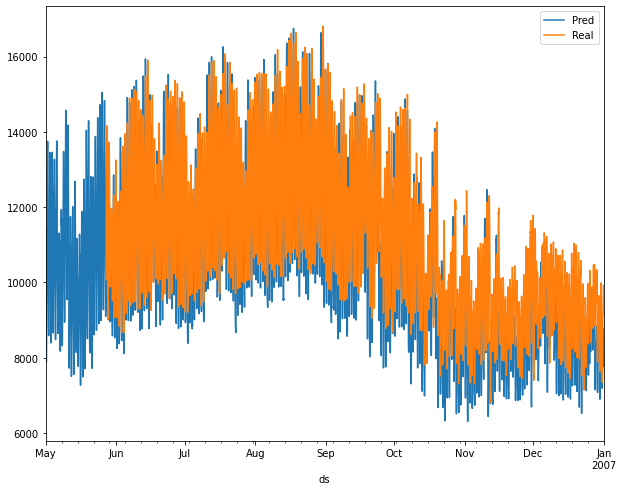

In [6]:
forecast_test = m.predict(ts_test)
fig,ax = plt.subplots(figsize=(10,8))
ts.set_index('ds').loc['2006-05':,'y'].plot(ax=ax,label='Pred')
forecast_test.set_index('ds').loc['2006-05':,'yhat24'].plot(ax=ax,label='Real')
ax.legend()
plt.savefig('initial_test_final_pure.png')
plt.show()


In [7]:
last_day = 60
print(f'mean_absolute_percentage_error for last {last_day} days is:')
print(mean_absolute_percentage_error(ts.set_index('ds')['y'].iloc[-24*last_day:], forecast_test.set_index('ds')['yhat24'].iloc[-24*last_day:]))

mean_absolute_percentage_error for last 60 days is:
0.10556894057323186


# Optuna

- ハイパーパラメータの検索範囲の定義
    - 各ハイパーパラメータの検索範囲を含む境界変数を定義
    
- nph_warper
    - 各パラメータは異なる方法でサンプリングされる場合がある
        - changepoints_range
            - 0.88888のようなパラメータは好まれないので、手動でリストを指定してOptunaサンプラーに抽出
        - trend_reg
            - 検索空間は、0.001から1で、ここでは対数レベル抽出法が使用される
            

In [8]:
default_para = dict(n_lags = n_lags,n_forecasts= n_forecasts,changepoints_range=0.8,n_changepoints=5, trend_reg=0.1,normalize='minmax',learning_rate =1)

param_types = dict(changepoints_range='float',n_changepoints='int',trend_reg='float',learning_rate='float',month_order = 'int',week_order ='int')
bounds = {'changepoints_range': [0.6,0.8,0.9],
          'n_changepoints': [4, 8],
          'trend_reg': [0.001, 1],
          'learning_rate': [0.001, 1],
          'month_order': [3, 8],
          'week_order': [2, 5],
         }


def create_nph(**para):
    temp_para = deepcopy(para)
    month_order = temp_para.pop('month_order')
    week_order = temp_para.pop('week_order')
    m = NeuralProphet(**temp_para)
    m = m.add_seasonality('my_month', 28, month_order)
    m = m.add_seasonality('my_week', 7, week_order)
    return m

def nph_warper(trial,ts):
    params = {}
    params['changepoints_range'] = trial.suggest_categorical('changepoints_range', bounds['changepoints_range'])
    params['n_changepoints'] = trial.suggest_int('n_changepoints', bounds['n_changepoints'][0], bounds['n_changepoints'][1])
    params['trend_reg'] = trial.suggest_loguniform('trend_reg', bounds['trend_reg'][0], bounds['trend_reg'][1])
    params['learning_rate'] = trial.suggest_loguniform('learning_rate', bounds['learning_rate'][0], bounds['learning_rate'][1])
    params['month_order'] = trial.suggest_int('month_order', bounds['month_order'][0], bounds['month_order'][1])
    params['week_order'] = trial.suggest_int('week_order', bounds['week_order'][0], bounds['week_order'][1])
    temp_para = deepcopy(default_para)
    temp_para.update(params)
    logger.info('*********************************')
    logger.info(temp_para)
    METRICS = ['SmoothL1Loss', 'MAE', 'RMSE']
    metrics_test = pd.DataFrame(columns=METRICS)
    m = create_nph(**temp_para)
    folds = m.crossvalidation_split_df(ts, freq="H", k=5, fold_pct=0.2, fold_overlap_pct=0.5)
    for df_train, df_test in folds:
        m = create_nph(**temp_para)
        train = m.fit(df_train)
        test = m.test(df=df_test)
        metrics_test = metrics_test.append(test[METRICS].iloc[-1])
    out = metrics_test['MAE'].mean()
    logger.info(out)
    return out


def objective(trial):
    ts = df_ercot[['ds', 'COAST']].copy() #select column associated with region
    ts = ts.iloc[:26301, :].copy() #selects data up to 26301 row (2004 to 2007 time stamps)
    ts = ts.rename(columns = {'COAST': 'y'}) #rename column of data to 'y' which is compatible with Neural Prophet
    return nph_warper(trial,ts)

In [9]:
study = optuna.create_study(direction='minimize',study_name='nph_tuning', storage="sqlite:///nph.db")
study.optimize(objective, n_trials=15, n_jobs=-1)

# study = optuna.load_study(study_name='nph_tuning', storage="sqlite:///nph.db")
# study.optimize(objective, n_trials=5)

[I 2022-10-31 06:10:22,312] A new study created in RDB with name: nph_tuning
WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

2022-10-31 06:10:22.552 | INFO     | __main__:nph_warper:32 - *********************************
2022-10-31 06:10:22.558 | INFO     | __main__:nph_warper:33 - {'n_lags': 24, 'n_forecasts': 24, 'changepoints_range': 0.9, 'n_changepoints': 8, 'trend_reg': 0.02057416348386249, 'no

In [10]:
study.best_trial

FrozenTrial(number=12, values=[475.0112627315194], datetime_start=datetime.datetime(2022, 10, 31, 7, 54, 4, 111697), datetime_complete=datetime.datetime(2022, 10, 31, 8, 10, 31, 909126), params={'changepoints_range': 0.6, 'learning_rate': 0.004252102827392428, 'month_order': 3, 'n_changepoints': 7, 'trend_reg': 0.9942952162061238, 'week_order': 4}, distributions={'changepoints_range': CategoricalDistribution(choices=(0.6, 0.8, 0.9)), 'learning_rate': FloatDistribution(high=1.0, log=True, low=0.001, step=None), 'month_order': IntDistribution(high=8, log=False, low=3, step=1), 'n_changepoints': IntDistribution(high=8, log=False, low=4, step=1), 'trend_reg': FloatDistribution(high=1.0, log=True, low=0.001, step=None), 'week_order': IntDistribution(high=5, log=False, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=13, state=TrialState.COMPLETE, value=None)

In [11]:
study.best_params

{'changepoints_range': 0.6,
 'learning_rate': 0.004252102827392428,
 'month_order': 3,
 'n_changepoints': 7,
 'trend_reg': 0.9942952162061238,
 'week_order': 4}

In [12]:
best_para = deepcopy(default_para)
best_para.update(study.best_params)

m_best = create_nph(**best_para)
ts_train, ts_test = m_best.split_df(ts, valid_p = 0.2, local_split = True)
after_metrics = m_best.fit(ts_train)


INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as H
INFO - (NP.forecaster.__handle_missing_data) - 3 missing dates added.
WARNING - (NP.forecaster.__handle_missing_data) - 3 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 3 NaN values in column y were auto-imputed.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.995% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.981% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.981% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


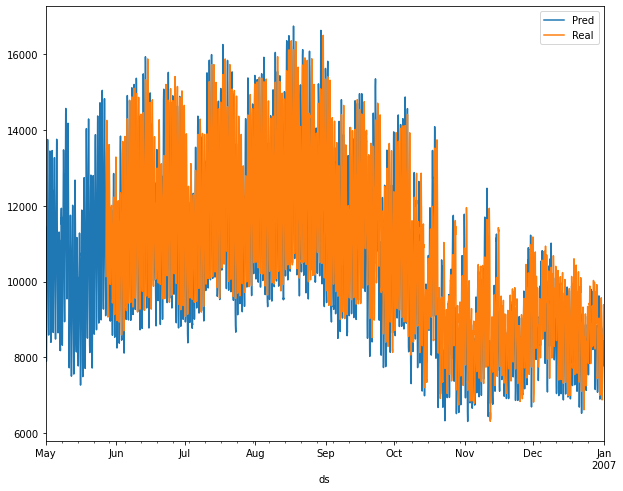

In [13]:
after_forecast_test = m_best.predict(ts_test) # Predict ：つまり予測。ここに新データを合わせて予測を行う
after_forecast_test
fig,ax = plt.subplots(figsize=(10,8))
ts.set_index('ds').loc['2006-05':,'y'].plot(ax=ax,label='Pred')
after_forecast_test.set_index('ds').loc['2006-05':,'yhat24'].plot(ax=ax,label='Real')
ax.legend()
plt.savefig('tuining_final_pure.png')
plt.show()

In [14]:
print(f'mean_absolute_percentage_error for last {last_day} days is:')
print(mean_absolute_percentage_error(ts.set_index('ds')['y'].iloc[-24*last_day:], after_forecast_test.set_index('ds')['yhat24'].iloc[-24*last_day:]))

mean_absolute_percentage_error for last 60 days is:
0.06235116258721036


# Visualization
# optuna.visualization.plot_param_importances
**optuna.visualization.plot_param_importances(study, evaluator=None, params=None, *, target=None, target_name='Objective Value')**

- ハイパーパラメータ調整結果の可視化
    - Optunaは、チューニングプロセス中に何が起こっているのかを理解するのに役立つさまざまな可視化を提供
    - ●どのハイパーパラメータを選択したかがより重要か、確認可能

### **ハイパーパラメーターの重要度をプロット**

>**study ( Study )** – 最適化されたスタディ。
>
>**evaluator ( Optional [ BaseImportanceEvaluator ] )** – 重要性の評価をどのアルゴリズムに基づいて行うかを指定する重要性評価器オブジェクト。デフォルトはFanovaImportanceEvaluatorです。。
>
>**params (Optional[List[str]])** – 評価するパラメータ名のリスト。None の場合、完了したすべてのトライアルで存在するすべてのパラメータが評価される。
>
>**target (Optional[Callable[[FrozenTrial], float]])** – 表示する値を指定する関数です。None で、study が単一目的最適化に使用されている場合、目的値がプロットされる。
>
>                          study が多目的最適化に使用される場合、この引数を指定する。
>                          例えば、第一目的のハイパーパラメータの重要度を得るには、 target=lambda t: t.values[0] をターゲットパラメータに使用します。
>**target_name (str)** - 軸ラベルに表示するターゲットの名前。



In [15]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(
    width=1000,
    height=500   
)
fig.show()

# optuna.visualization.plot_optimization_history
**optuna.visualization.plot_optimization_history(study,  *,  target=None, target_name='Objective Value', error_bar=False)**

- 調整パラメータの履歴を表示する。Plotlyで表示する事によって、どのObject Valueがベストであったかが可視化できる。

## **スタディ内のすべての試行の最適化履歴をプロット**

> **(Union[Study,Sequence[Study]])** - 目標値に対して試行がプロットされたStudyオブジェクト。これらの最適化履歴を比較したい場合は、複数のStudyを渡すことができます。
>
> **target (Optional[Callable[[FrozenTrial],float]])** - 表示する値を指定する関数。Noneでstudyが単一目的最適化に使用されている場合、目的値がプロットされる。
>
>                                        study が多目的最適化に使用される場合、この引数を指定する。
> **target_name (str)** – 軸ラベルと凡例に表示されるターゲットの名前です
>
> **error_bar (bool)** - エラーバーを表示するためのフラグです。

In [16]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(
    width=1000,
    height=500   
)
fig.show()

# optuna.visualization.plot_parallel_coordinate
**optuna.visualization.plot_parallel_coordinate(study, params=None, *, target=None, target_name='Objective Value')**

### 研究の高次元のパラメータ関係をプロットする。

### パラメータに欠損値がある場合、欠損値のある試験はプロットされないことに注意。

> **study (Study)** – 試行が目標値に対してプロットされるStudyオブジェクト。
>
> **params (Optional[List[str]])** – 可視化するパラメータリスト。デフォルトは全パラメーターです。
>
> **target (Optional[Callable[[FrozenTrial], float]])** – 表示する値を指定する関数です。None で、study が単一目的最適化に使用されている場合、目的値がプロットされる。
>                                study が多目的最適化に使用される場合、この引数を指定する。
>
> **target_name (str)** – 軸ラベルと凡例に表示するターゲットの名前。

In [17]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(
    width=1000,
    height=500   
)
fig.show()

In [18]:
fig = optuna.visualization.plot_edf(study)
fig.update_layout(
    width=1000,
    height=500   
)

In [19]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(
    width=1000,
    height=500   
)

In [20]:
fig = optuna.visualization.plot_intermediate_values(study)
fig.update_layout(
    width=1000,
    height=500   
)

[W 2022-10-31 08:19:33,878] You need to set up the pruning feature to utilize `plot_intermediate_values()`


In [21]:
fig = optuna.visualization.plot_pareto_front(study)
fig.update_layout(
    width=1000,
    height=500   
)

ValueError: `plot_pareto_front` function only supports 2 or 3 objective studies when using `targets` is `None`. Please use `targets` if your objective studies have more than 3 objectives.

In [22]:
fig = optuna.visualization.plot_slice(study)
fig.update_layout(
    width=1000,
    height=500   
)

In [23]:
fig = optuna.visualization.is_available()
print(fig)

True


# LogisticRegressionによる予測　：　(非Prophet予測)
# **OptunaとK分割交差検証**

## **K分割交差検証を実施**

- Optunaを用いる前にK分割交差検証を実施

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import datasets

import numpy as np
import optuna


cancer = datasets.load_breast_cancer()

X = cancer.data
y = 1 - cancer.target

X_train, X_testm y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Solver : 最適化
#  'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga' : default : lbfgs
# max_iter : 最大反復回数　：　デフォルト100
model = LogisticRegression(solver='lbfgs', max_iter=10000)

# 訓練
model.fit(X_train, y_train)

# 予測
pred = model.predict(X_test)

# 正解率を出力
accuracy = 100.0 * accuracy_score(y_test, pred)
print(f"正解率 : {accuracy}")

In [ ]:
# K分割交差検証　:　5分割交差検証
scores = cross_val_score(model, X_train, y_train, cv=5)

print(f"5分割交差検証: {100 * scores.mean()}")

# Optunaでハイパーパラメータを最適化する
- optuna.create_study()を実行し、optuna.studyインスタンスを作る
- study.optimize()

In [2]:
class Objective:
    
    def __init__(self, X, y):
        # 変数X,yの初期化
        self.X = X
        self.y = y
        
    def __call__(self, trial):
        # ハイパーパラメータの設定
        params = {
            # 最適化アルゴリズムを指定
            'solver': trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
            # 正則化の強さを指定：モデルの制約　(0.0001~10)
            'C': trial.suggest_loguniform('C', 0.0001, 10),
            # 最大反復回数(*ソルバー収束まで)
            'max_iter': trial.suggest_int('max_iter', 100, 100000)
        }
        
        model = LogisticRegression(**params)
        
        # 評価指標として正解率の最大化を目指す
        scores = cross_validate(model, X=self.X, y=self.y, scoring='accuracy', n_jobs=-1)
        
        return scores['test_score'].mean()

In [ ]:
# ハイパーパラメータの探索
objective = Objective(X_train, y_train)
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=60)

# ベストパラメータを出力
print('params:', study.best_params)

# **[Optuna Visualization](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#visualization)**

In [ ]:
from optuna.visualization import plot_contour, plot_edf, plot_intermediate_values, plot_optimization_history, plot_parallel_coordinate, plot_param_importances, plot_slice
plot_contour(study)
plot_edf(study)

In [ ]:
# study.best_params
# print(study.best_params['solver'])
# print(study.best_params['max_iter'])
# print(study.best_params['C'])
# print(study.best_value)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, precision_score

model = LogisticRegression(
    # ハイパーパラメータ探査で特定した値を設定
    solver = study.best_params['solver'], 
    C = study.best_params['C'], 
    max_iter = study.best_params['max_iter']
)

# 訓練
model.fit(X_train, y_train)

# 予測(テスト)
pred = model.predict(X_test)

## テストの予測と実際の予測を計測
# 正解率の出力
print('Accuracy : {:.5f}'.format(100 * accuracy_score(y_test, pred)))

# 混同行列
print(confusion_matrix(y_test, pred))

# 適合率
print(f"Precision : {100 * precision_score(y_test, pred):.5f}")

# 再現率

print(f"Recall : {100 * recall_score(y_test, pred)}")

---
---

# **変化するトレンドへの適合(NeuralProphet)**



In [27]:
data_location = "../input/peyton-manning/example_wp_log_peyton_manning.csv"

In [30]:
df = pd.read_csv(data_location)
df.head(3)

ds         y
0  2007-12-10  9.590761
1  2007-12-11  8.519590
2  2007-12-12  8.183677

- どのようなカスタマイズもなく、初期モデルを適合させる事が可能
    - データ頻度をDailyに指定する
        - モデルは後で未来を予測する時にこれを記憶する

In [34]:
m = NeuralProphet()
metrics = m.fit(df, freq="D")
metrics.head(3)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 142


  0%|          | 0/136 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.36E-01, min: 1.58E-01


  0%|          | 0/136 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.36E-02, min: 1.36E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.76E-01
Epoch[142/142]: 100%|██████████| 142/142 [00:24<00:00,  5.91it/s, SmoothL1Loss=0.00612, MAE=0.346, RMSE=0.483, Loss=0.0047, RegLoss=0] 


SmoothL1Loss       MAE      RMSE      Loss  RegLoss
0      0.914374  6.034792  7.313731  0.673007      0.0
1      0.601986  4.488643  5.563549  0.428496      0.0
2      0.306240  2.948192  3.668848  0.206095      0.0

- 返されるメトリック・データフレームは各訓練エポックのための記録されたメトリックを含む
    - 予測するためのデータフレームを作成。未来へ1年間を予測することを望みそして履歴全体を含めることを望む事を指定

In [35]:
future = m.make_future_dataframe(df, periods=365, n_historic_predictions=len(df))
future.tail(3)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


ds   y
3267 2017-01-17 NaN
3268 2017-01-18 NaN
3269 2017-01-19 NaN

In [36]:
forecast = m.predict(future)
print(list(forecast.columns))

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.083% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.083% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


['ds', 'y', 'residual1', 'yhat1', 'trend', 'season_yearly', 'season_weekly']


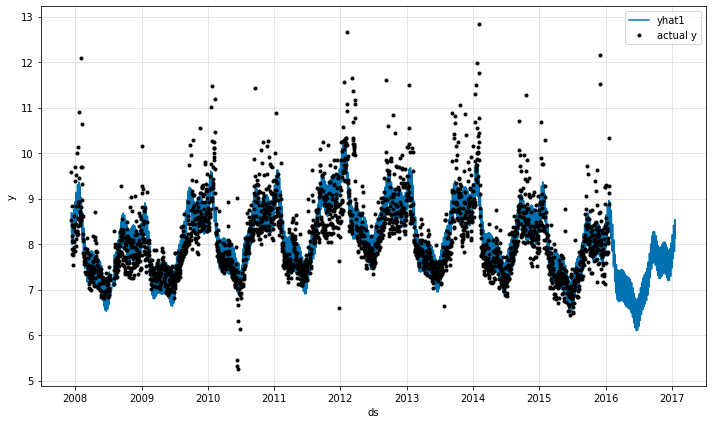

In [37]:
fig1 = m.plot(forecast)

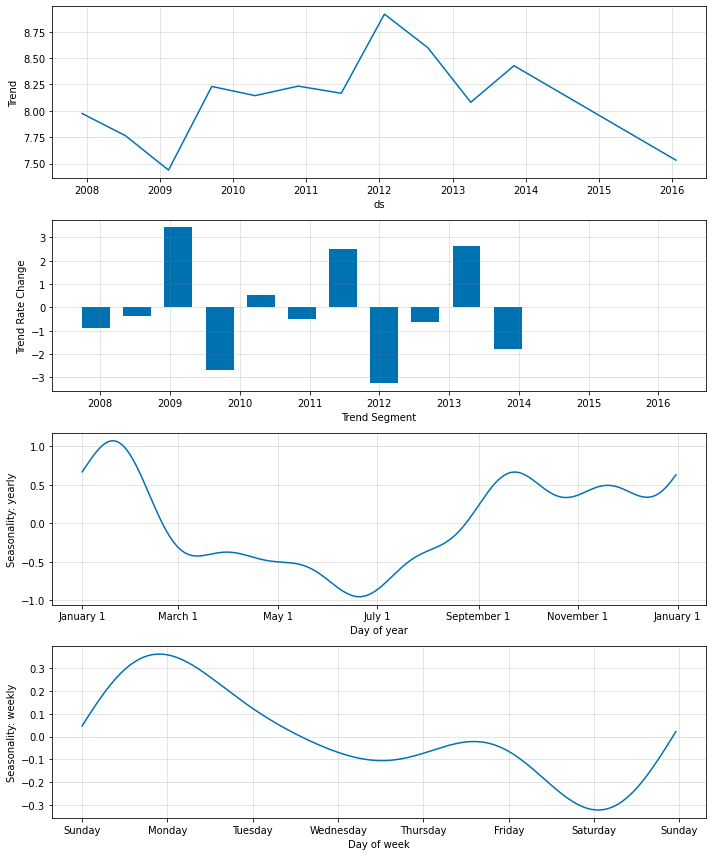

In [38]:
fig2 = m.plot_parameters()

## **残差(階差)表示**

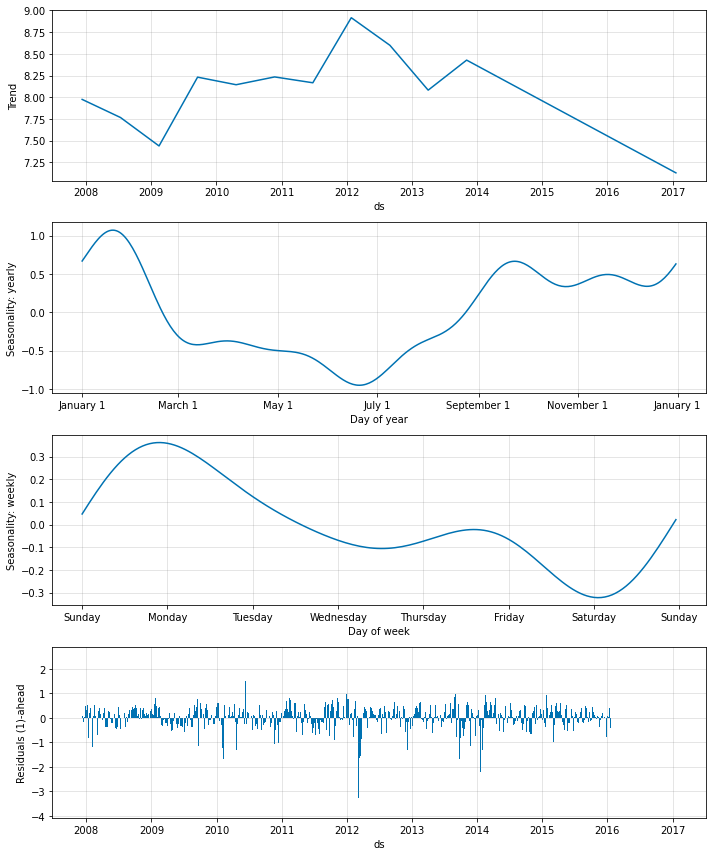

In [39]:
fig3 = m.plot_components(forecast, residuals=True)

- 上記ではデフォルト値でも上手く機能するが、デフォルトはトレンドの実際の変化がポイント間の領域にたまたま収まる場合には十分ではないかもしれない

- トレンドの柔軟性の増加
    - 過剰適合の危険性において、変化点の数を増やし、トレンドにより柔軟性を与えることでこれに対処する
        - 変化点の数を30に増やす。
        - 最後の10%だけを(デフォルト20%)除外するために、トレンド変化点を適合させるデータの範囲を増やせる
            - changepoints_range=0.90とする事で10%


- **以下のトレンドレートの変化を見ると、トレンドが短期的な変動に過剰適合していることが明白になる**

In [40]:
m = NeuralProphet(n_changepoints=30, changepoints_range=0.90)
metrics = m.fit(df, freq="D")

future = m.make_future_dataframe(df, n_historic_predictions=len(df))
forecast = m.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 142


  0%|          | 0/136 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.58E-01, min: 1.85E+00


  0%|          | 0/136 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.36E-01, min: 1.58E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.29E-01
Epoch[142/142]: 100%|██████████| 142/142 [00:24<00:00,  5.88it/s, SmoothL1Loss=0.00551, MAE=0.329, RMSE=0.456, Loss=0.00425, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.968% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.968% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_fo

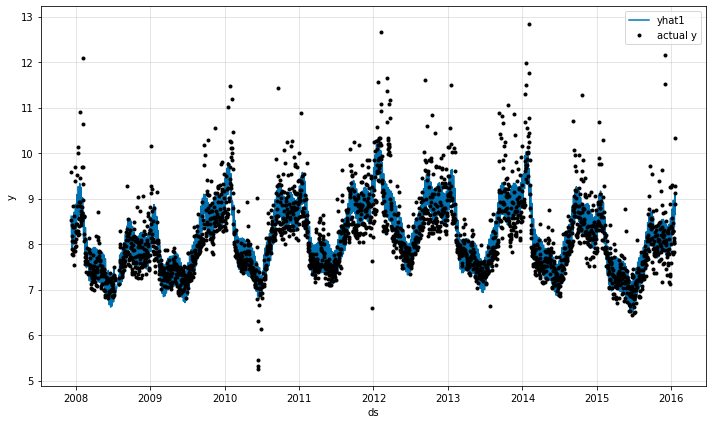

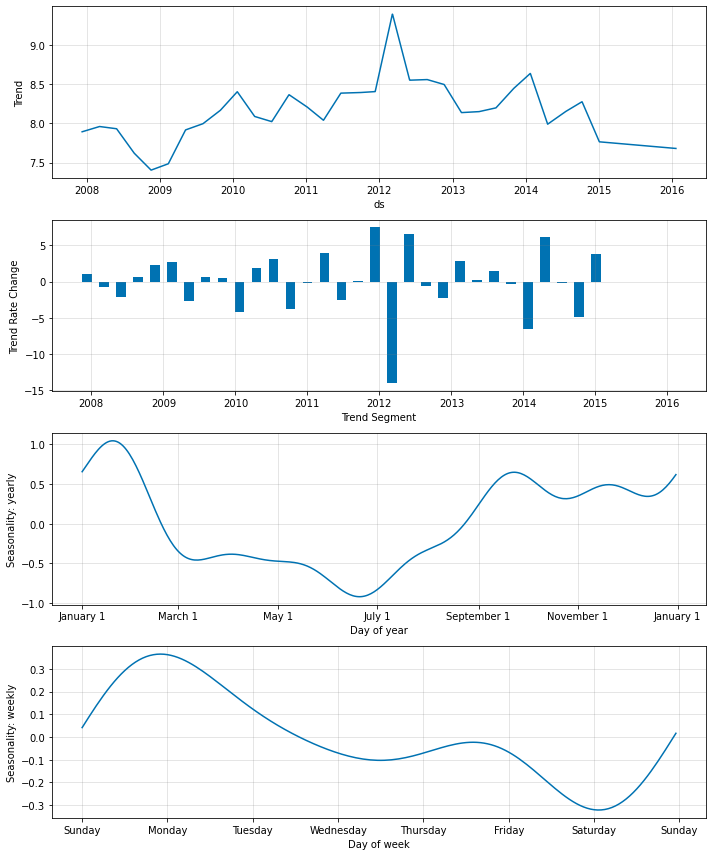

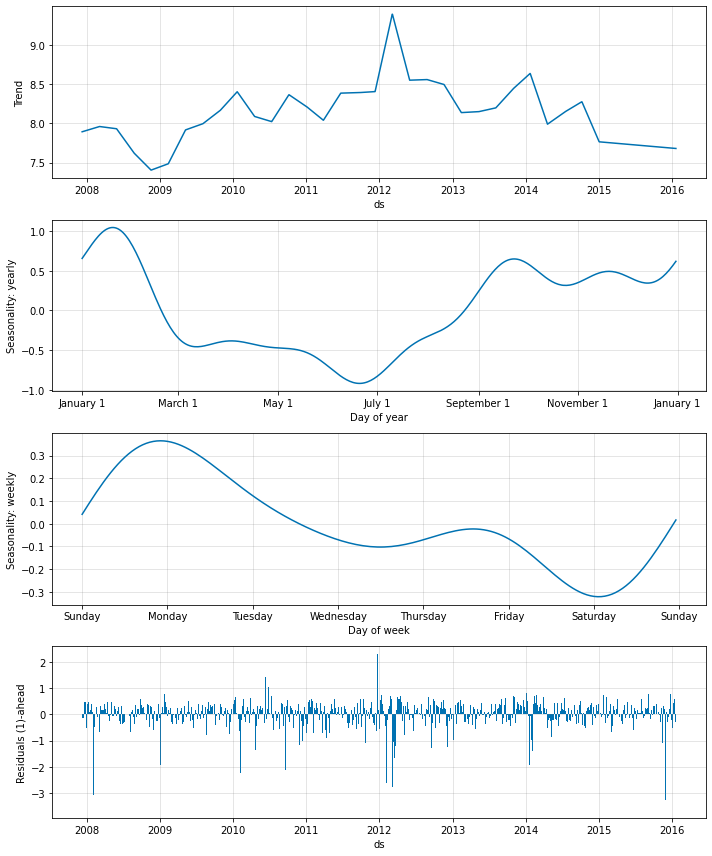

In [43]:
fig1 = m.plot(forecast)
fig2 = m.plot_parameters()
fig3 = m.plot_components(forecast, residuals=True)

- **トレンドレートの変化を見ると、トレンドが短期的な変動に過剰適合していることが明白になる**
- 自動トレンドポイント選択
    - 正則化を追加することで、最も関連性のある変化点の自動選択を実現できて、ゼロに近い他のポイントのレート変化を引き出すことが可能

In [45]:
m = NeuralProphet(n_changepoints=30, trend_reg=1.00, changepoints_range=0.90)

metrics = m.fit(df, freq="D")

future = m.make_future_dataframe(df, n_historic_predictions=len(df))
forecast = m.predict(future)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 142


  0%|          | 0/136 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.15E-02, min: 2.93E-01


  0%|          | 0/136 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.15E-02, min: 8.58E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.59E-02
Epoch[142/142]: 100%|██████████| 142/142 [00:25<00:00,  5.55it/s, SmoothL1Loss=0.00639, MAE=0.358, RMSE=0.496, Loss=0.039, RegLoss=0.0341]   
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.968% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.968% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_origi

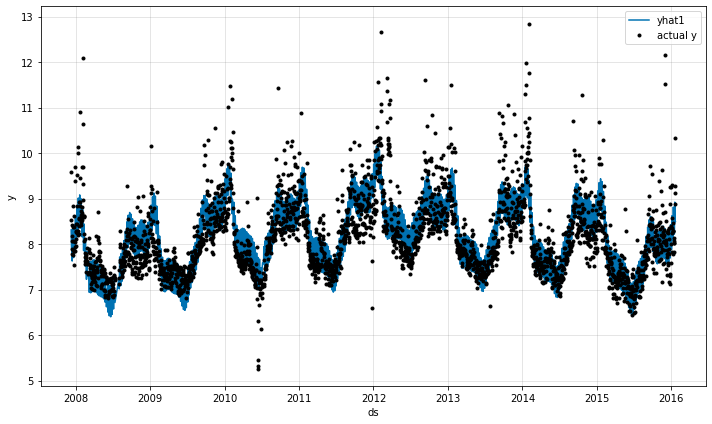

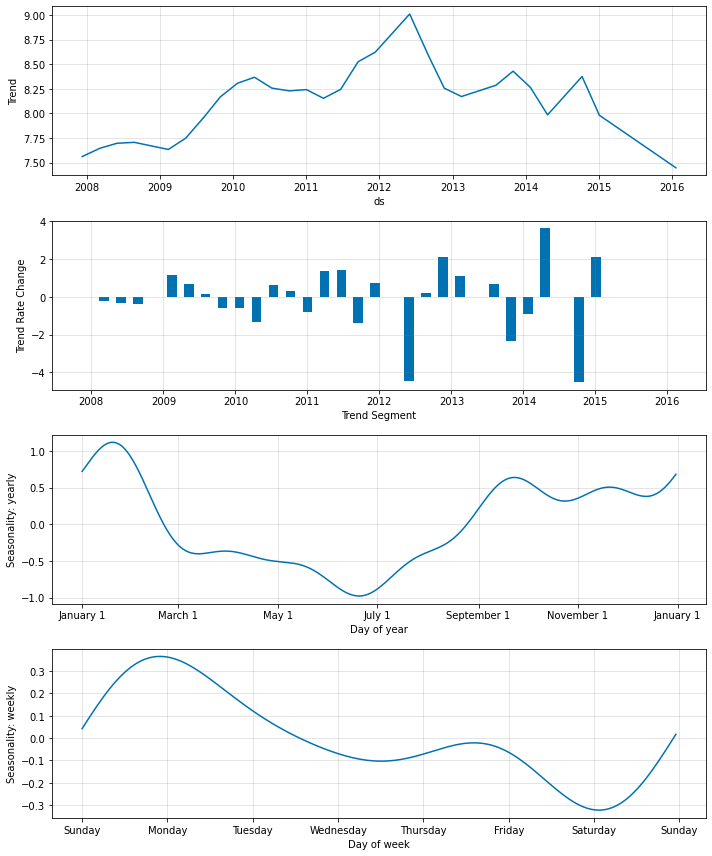

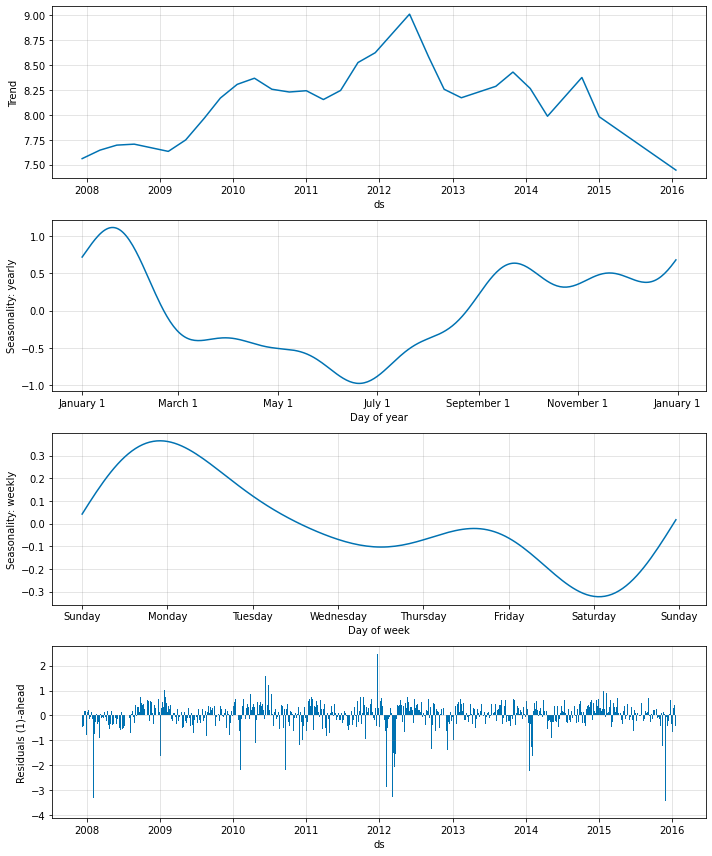

In [47]:
fig1 = m.plot(forecast)
fig2 = m.plot_parameters()
fig3 = m.plot_components(forecast, residuals=True)

- 手動トレンド調整
    - トレンド変化点の手動による指定
        - 以下のTrendChangeポイントの指定は、PlotのTrendの位置を参照。その位置に該当した値を入力している。

In [48]:
m = NeuralProphet(
    changepoints=['2012-01-01', '2014-01-01'],
)
metrics = m.fit(df, freq="D")
future = m.make_future_dataframe(df, n_historic_predictions=len(df))
forecast = m.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 142


  0%|          | 0/136 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.17E-01, min: 1.36E+00


  0%|          | 0/136 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.58E-01, min: 1.17E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.23E-01
Epoch[142/142]: 100%|██████████| 142/142 [00:25<00:00,  5.60it/s, SmoothL1Loss=0.00684, MAE=0.366, RMSE=0.512, Loss=0.00516, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.968% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.968% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_fo

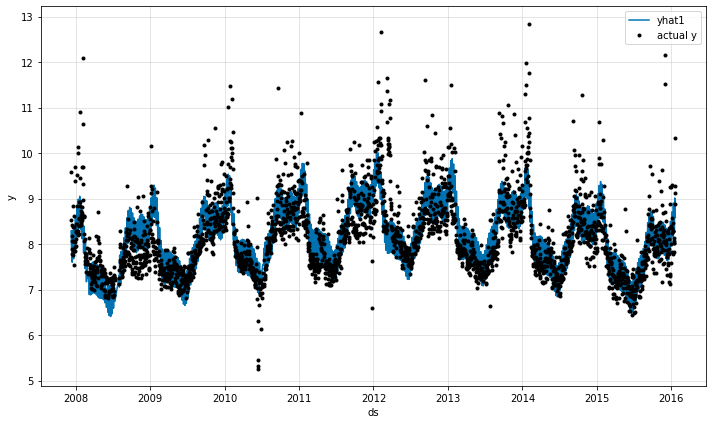

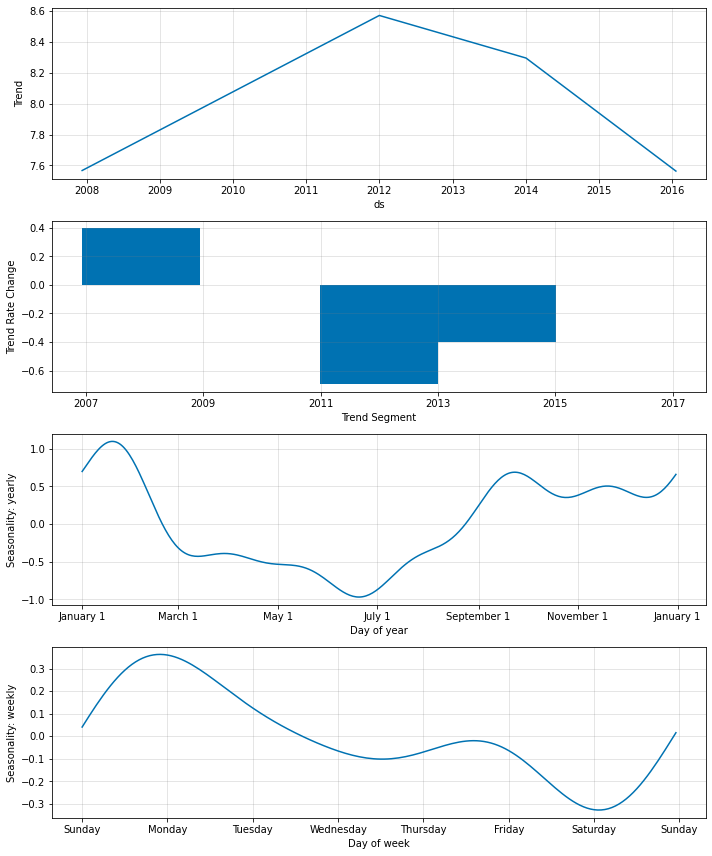

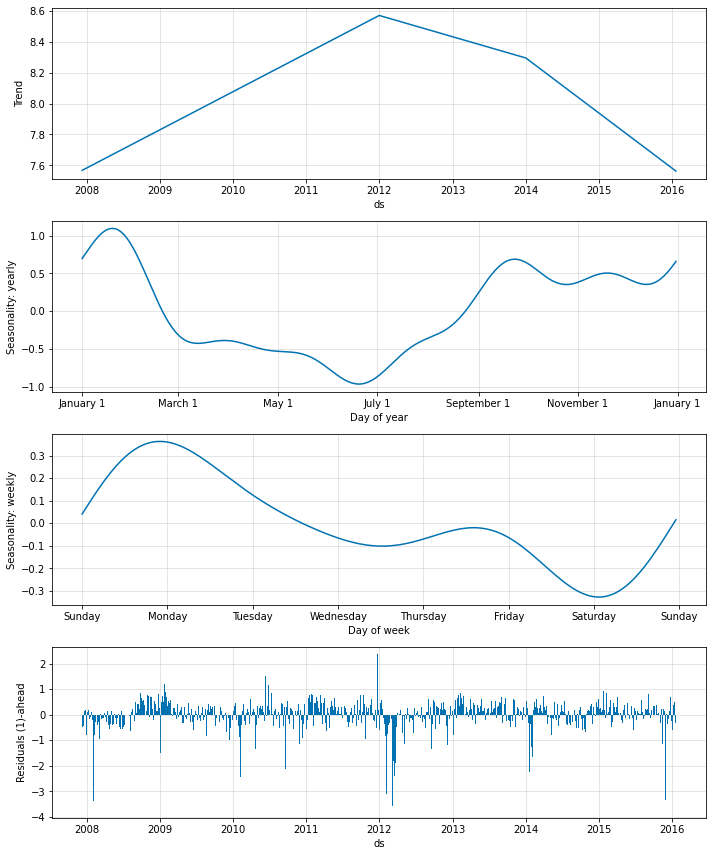

In [49]:
fig1 = m.plot(forecast)
fig2 = m.plot_parameters()
fig3 = m.plot_components(forecast, residuals=True)

# トレンドの柔軟性を微調整
- トレンドの柔軟性の微調整は、訓練にどの部分が影響しているのか、をOptunaでPlotすればよく認識できる。

- 非ゼロ・レート変化を持つポイントを多かれ少なかれ得る為に正則化の強さを調整できる
- 高すぎる正則化強度では、モデルの適合プロセスが不安定になる。

In [52]:
m = NeuralProphet(
    n_changepoints=30,
    trend_reg=5.00,
    changepoints_range=0.90,   
)
metrics = m.fit(df, freq="D")
future = m.make_future_dataframe(df, n_historic_predictions=len(df))
forecast = m.predict(future)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 142


  0%|          | 0/136 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 2.51E-01


  0%|          | 0/136 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.58E-01, min: 2.93E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.05E-01
Epoch[142/142]: 100%|██████████| 142/142 [00:24<00:00,  5.74it/s, SmoothL1Loss=0.00712, MAE=0.373, RMSE=0.52, Loss=0.00891, RegLoss=0.0035]  
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.968% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.968% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_origi

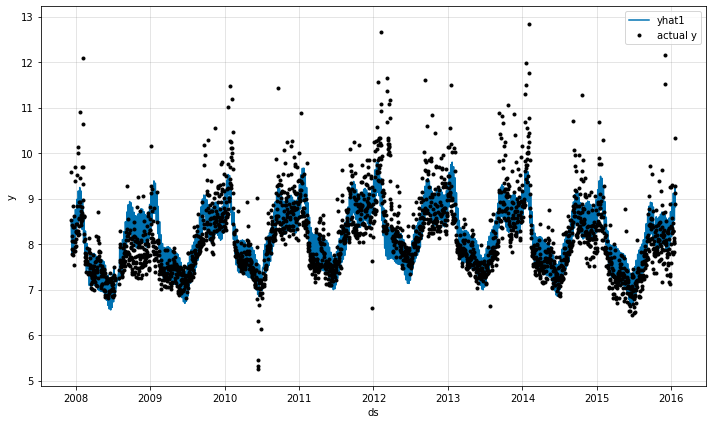

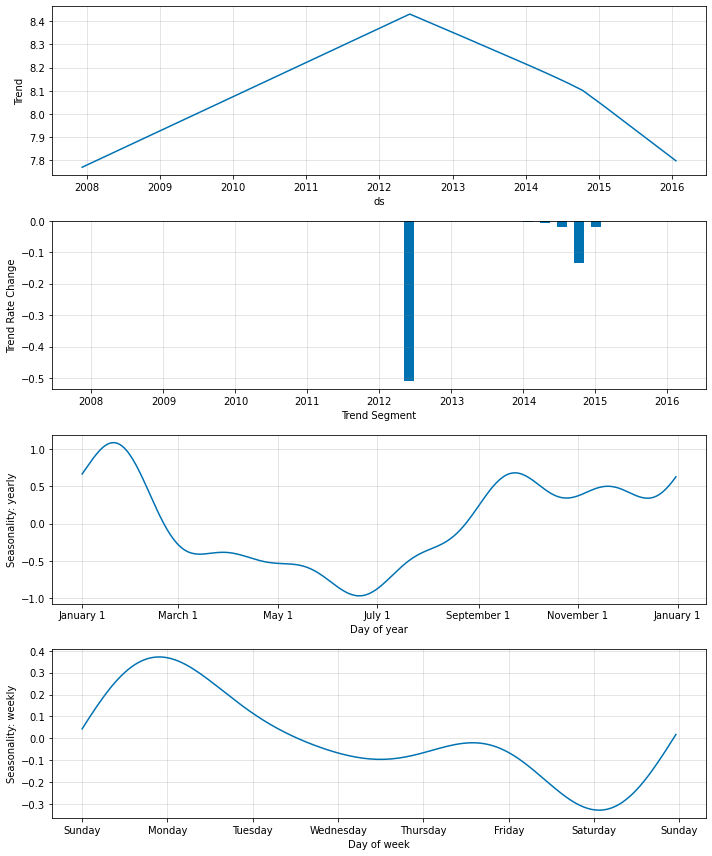

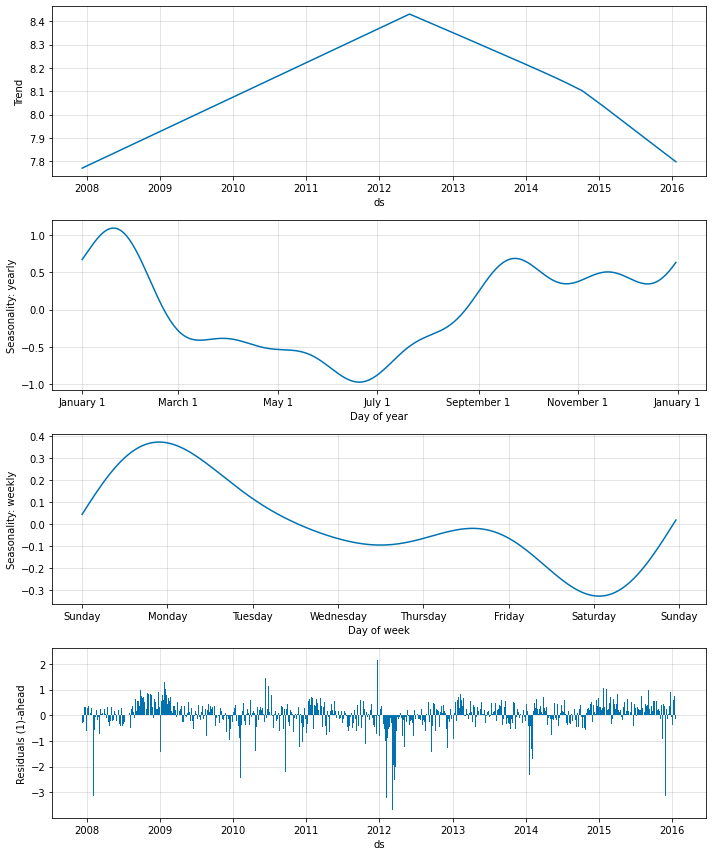

In [53]:
fig1 = m.plot(forecast)
fig2 = m.plot_parameters()
fig3 = m.plot_components(forecast, residuals=True)

---
---

# sub-dailyデータ
- 

In [3]:
# raw files : Github > csv > raw > 
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets_raw/yosemite_temps.csv"

In [4]:
df = pd.read_csv(data_location)
df.head(3)

ds     y
0  2017-05-01 00:00:00  27.8
1  2017-05-01 00:05:00  27.0
2  2017-05-01 00:10:00  26.8

- 次の7日間を予測することを試みる
    - 5分データ解像度は　$60/5 * 24 = 288$ : **このような感じでデータの解像度を決める**
    - daily値を持つ。したがって先の $7 * 288$ 期間を予測する事を望む。
        - 幾つかの常識を使用して以下を設定する。
            - 最初に、weekly季節性を無効にする。**自然は人間の週のカレンダーに従わない**
            - 2番目に、変化点を無効にする。**データセットは2か月のデータだけを含むから**
            

In [5]:
m = NeuralProphet(n_changepoints=0, weekly_seasonality=False)

metrics = m.fit(df, freq="5min")

future = m.make_future_dataframe(df, periods=7*288, n_historic_predictions=len(df))
forecast = m.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.995% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO - (NP.forecaster.__handle_missing_data) - dropped 12 NAN row in 'y'
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 88


  0%|          | 0/156 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.87E-01, min: 3.09E+00


  0%|          | 0/156 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.63E-01, min: 3.09E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.45E-01
Epoch[88/88]: 100%|██████████| 88/88 [00:41<00:00,  2.13it/s, SmoothL1Loss=0.00817, MAE=5.07, RMSE=6.9, Loss=0.00595, RegLoss=0] 
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.995% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.995% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.995% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils.return_df_in_origi

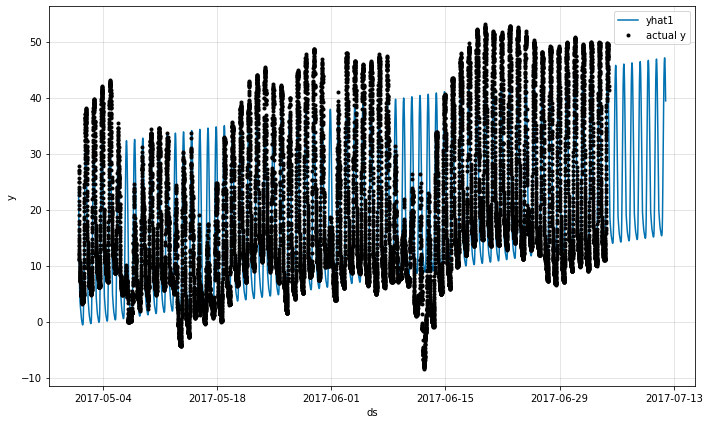

In [6]:
fig = m.plot(forecast)

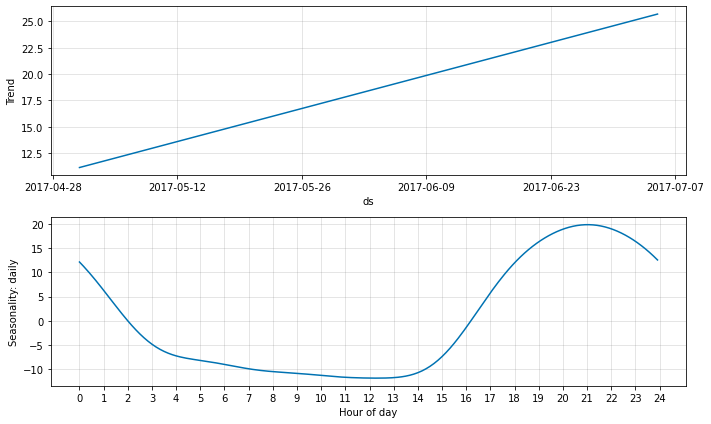

In [10]:
fig_param = m.plot_parameters()
#fig_comp = m.plot_components(forecast, residuals=True)

# トレンドと季節性を改良

- 288の記録されたdaily値を持つので、過剰適合の危険性なしに、daily_seasonalityの柔軟性を増やすことが出来る。
    - 天気が典型的であるように、**データがトレンドで明瞭に変化してしまう。ので(plot_conponent(residual=True)で確認できる)**
        - 変化点を無効にするという決定を再検討することを考える必要があるかもしれない。
            
            - 短期的な予測を行っているので、changepoints_rangeを増やす
            - トレンドの突然の変化に適合することを可能にするために、n_changepointsを増やす
            - 過剰適合を回避するために trend_reg を設定することにより、トレンド変化点を注意深く**正則化**する

In [11]:
m = NeuralProphet(changepoints_range=0.95, n_changepoints=50, trend_reg=1.5, weekly_seasonality=False, daily_seasonality=10)

metrics = m.fit(df, freq="5min")

future = m.make_future_dataframe(df, periods=60//5*24*7, n_historic_predictions=len(df))
forecast = m.predict(future)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.995% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO - (NP.forecaster.__handle_missing_data) - dropped 12 NAN row in 'y'
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 88


  0%|          | 0/156 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.90E+00, min: 7.54E-03


  0%|          | 0/156 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.06E+00, min: 8.62E-03
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.01E-01
Epoch[88/88]: 100%|██████████| 88/88 [00:55<00:00,  1.57it/s, SmoothL1Loss=0.00551, MAE=4.01, RMSE=5.65, Loss=0.0326, RegLoss=0.0288] 
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.995% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.995% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.995% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils.return_df_in_

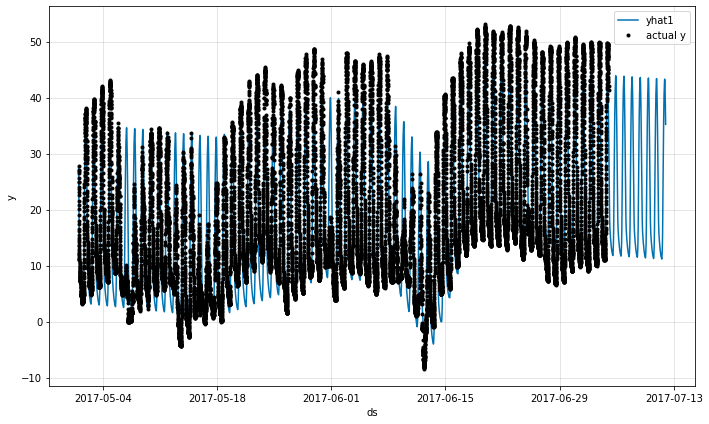

In [12]:
fig = m.plot(forecast)

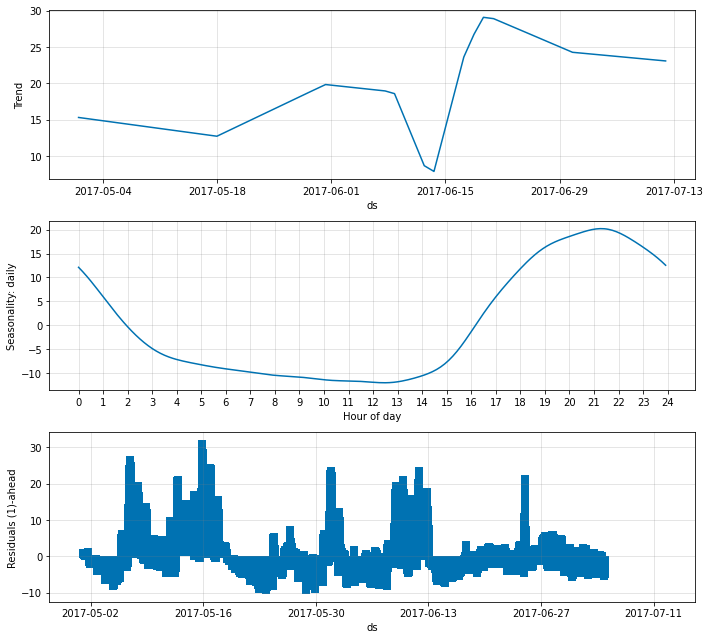

In [14]:
fig_comp = m.plot_components(forecast, residuals=True) # OFF

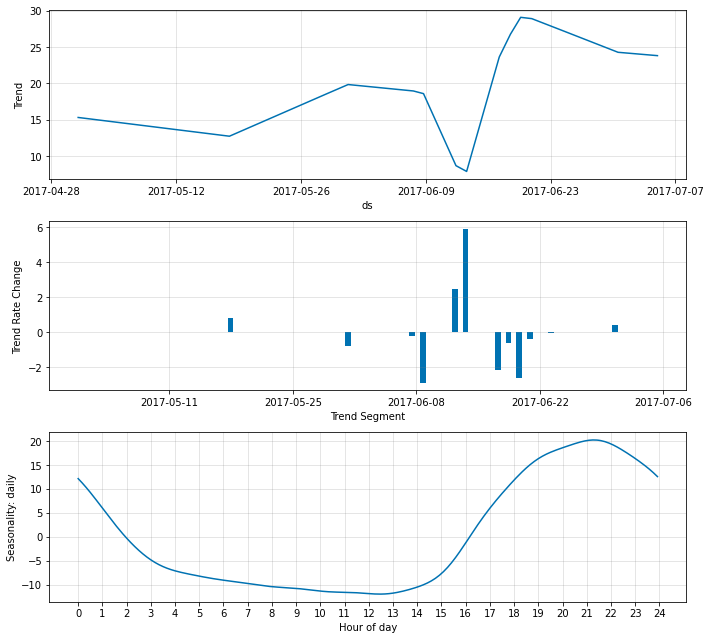

In [15]:
fig_param = m.plot_parameters()

---
---

# スパースな自己回帰

- NeuralProphetを5分解像度のデータに適合させる。(Yosemiteの毎日の気温)
- スパース性にフォーカス

In [19]:
m = NeuralProphet(n_lags=6*12, n_forecasts=3*12, changepoints_range=0.95, n_changepoints=30, weekly_seasonality=False, ar_reg=0.5)
metrics = m.fit(df, freq="5min") # validate_each_epoch=True, plot_live_loss=True

INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.995% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
WARNING - (NP.forecaster.__handle_missing_data) - 12 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 12 NaN values in column y were auto-imputed.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 88


  0%|          | 0/156 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.77E-03, min: 3.64E-01


  0%|          | 0/156 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.37E-02, min: 2.44E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.64E-02
Epoch[88/88]: 100%|██████████| 88/88 [01:43<00:00,  1.18s/it, SmoothL1Loss=0.00115, MAE=1.73, RMSE=2.59, Loss=0.00109, RegLoss=0.00025] 


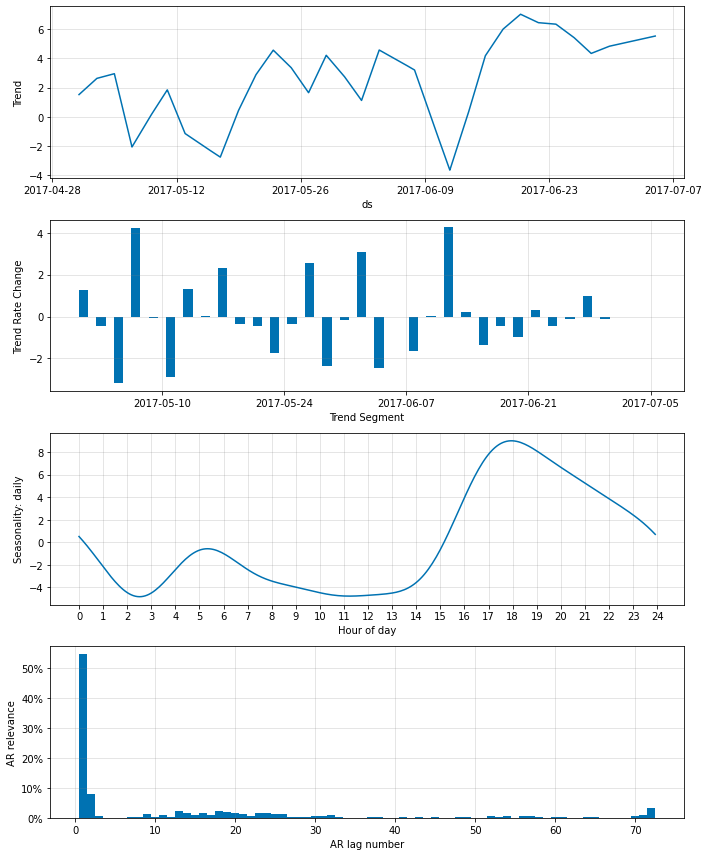

In [20]:
fig_param = m.plot_parameters()

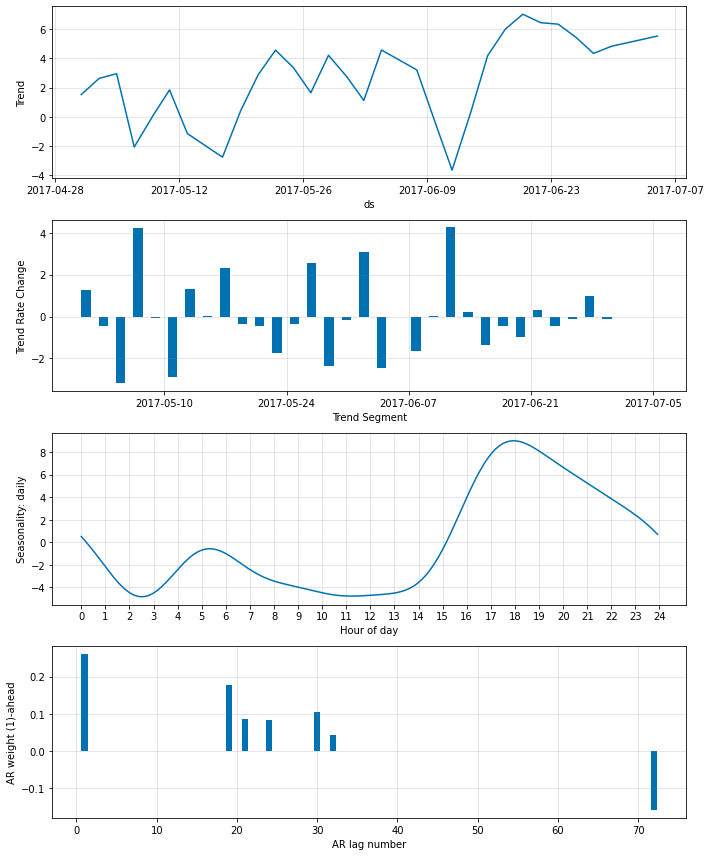

In [21]:
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig_param = m.plot_parameters()

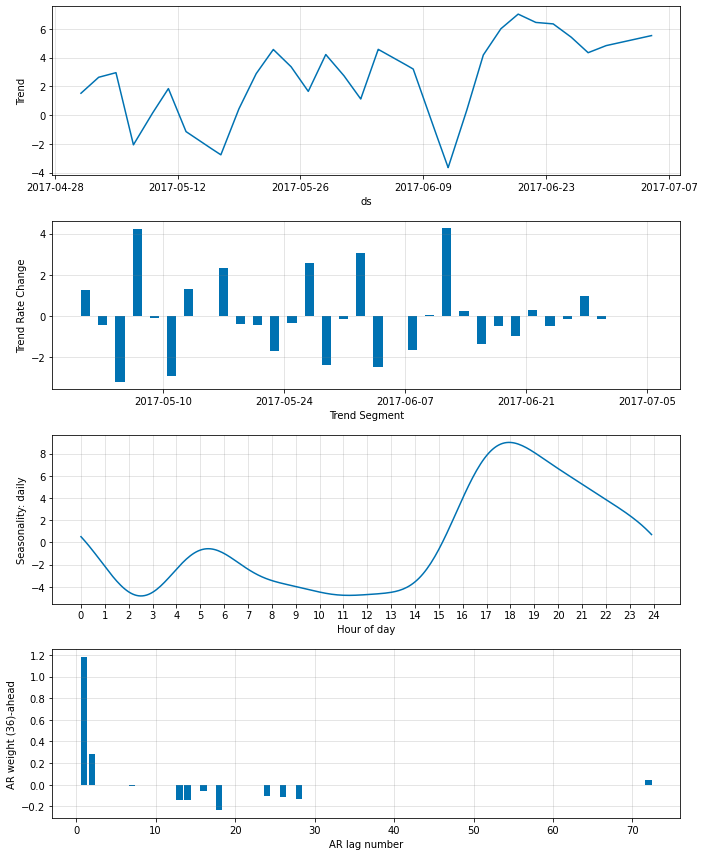

In [22]:
m = m.highlight_nth_step_ahead_of_each_forecast(36)
fig_param = m.plot_parameters()

- 非ゼロ　AR-係数を更に削減する
    - ar_lag を低く設定することで、非ゼロ重みの数を更に削減できる。ここではそれを10％に設定

In [24]:
m = NeuralProphet(
    n_lags=6*12,
    n_forecasts=3*12,
    changepoints_range=0.95,
    n_changepoints=30,
    weekly_seasonality=False,
#     batch_size=64,
#     epochs=100,    
#     learning_rate=0.1,
    ar_reg=0.1,
)
metrics = m.fit(df, freq='5min')

INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.995% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
WARNING - (NP.forecaster.__handle_missing_data) - 12 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 12 NaN values in column y were auto-imputed.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 88


  0%|          | 0/156 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.87E-02, min: 1.63E-01


  0%|          | 0/156 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.90E-02, min: 1.87E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.20E-02
Epoch[88/88]: 100%|██████████| 88/88 [01:44<00:00,  1.19s/it, SmoothL1Loss=0.00112, MAE=1.69, RMSE=2.56, Loss=0.000883, RegLoss=6.91e-5]


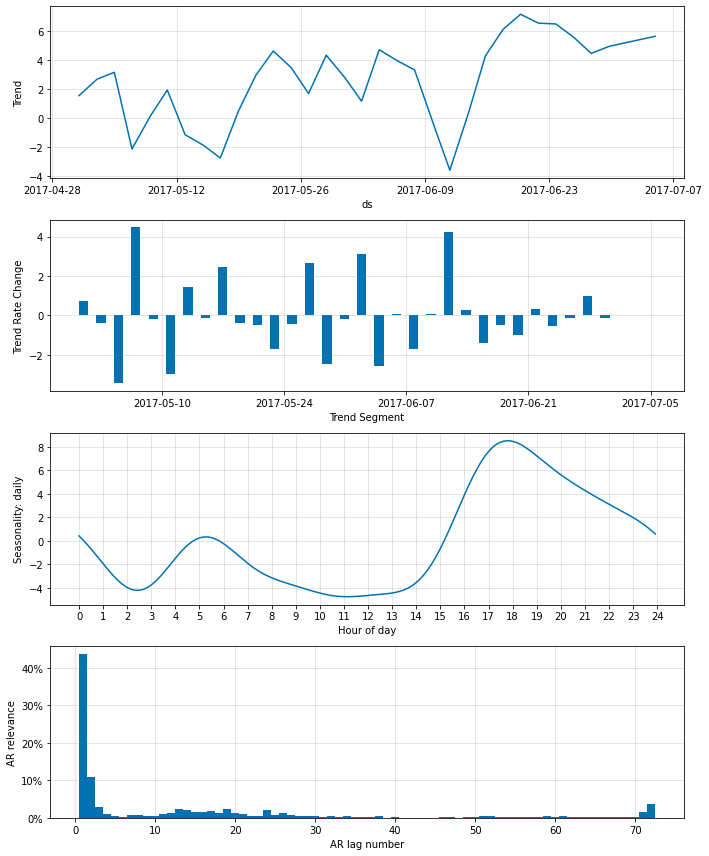

In [25]:
fig_param = m.plot_parameters()

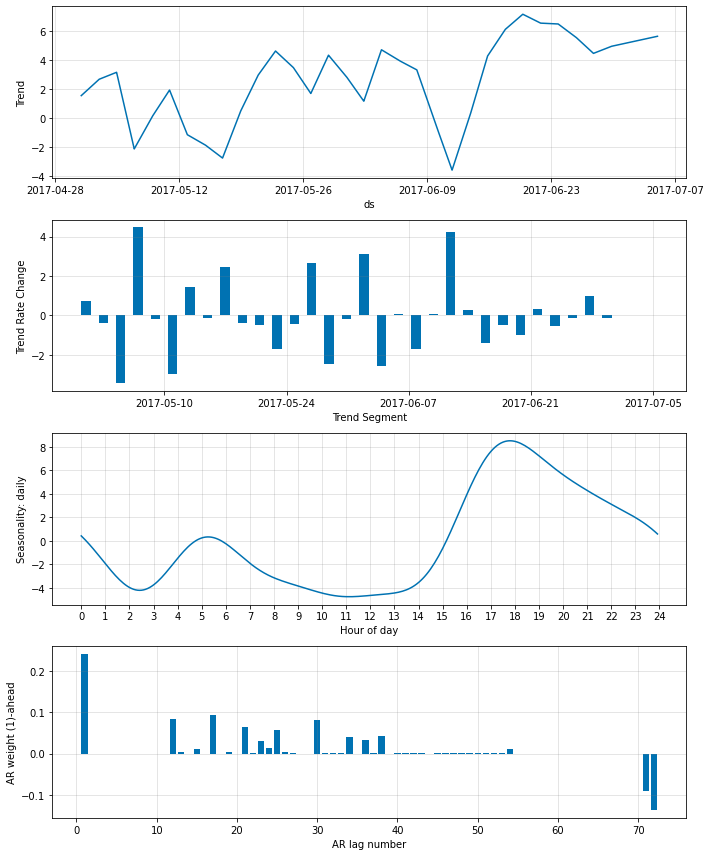

In [26]:
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig_param = m.plot_parameters()

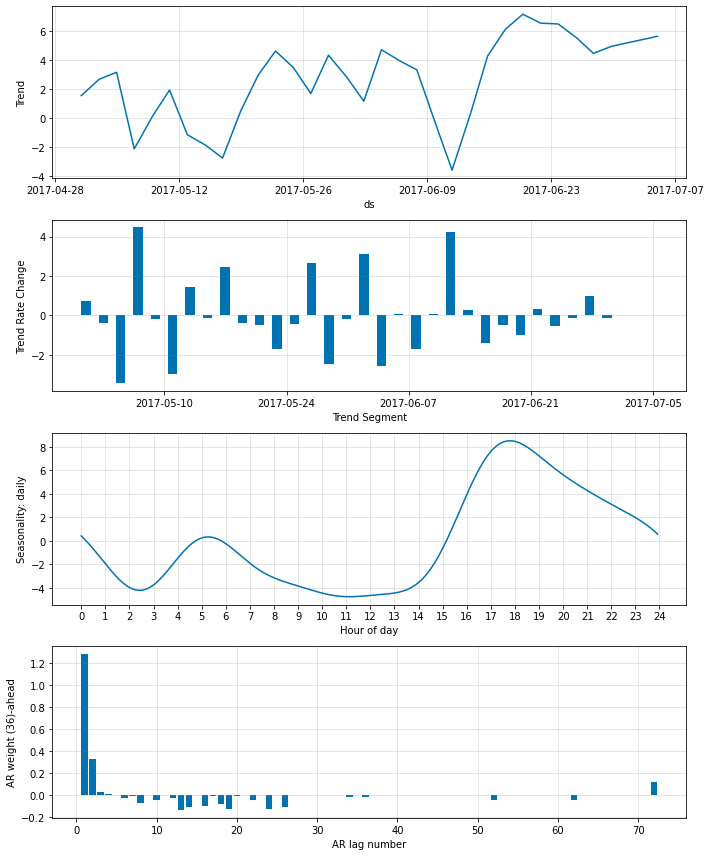

In [27]:
m = m.highlight_nth_step_ahead_of_each_forecast(36)
fig_param = m.plot_parameters()

- 極端なスパース性
    - より低く ar_reg　を設定すれば、より少ない非ゼロ重みがモデルにより適合される。
    - ここではそれを１％に設定、単一の非ゼロのラグに繋がる
        - **極端な値は訓練の不安定性に繋がる可能性がある**

In [44]:
m = NeuralProphet(
    n_lags=6*12,
    n_forecasts=3*12,
    changepoints_range=0.95,
    n_changepoints=30,
    weekly_seasonality=False,
#     batch_size=64,
#     epochs=100,    
#     learning_rate=0.1,
    ar_reg=0.01,
)
metrics = m.fit(df, freq='5min')

INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.995% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
WARNING - (NP.forecaster.__handle_missing_data) - 12 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 12 NaN values in column y were auto-imputed.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 88


  0%|          | 0/156 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.60E-02, min: 2.13E-01


  0%|          | 0/156 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.29E-02, min: 2.13E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.22E-02
Epoch[88/88]: 100%|██████████| 88/88 [01:44<00:00,  1.19s/it, SmoothL1Loss=0.00111, MAE=1.69, RMSE=2.55, Loss=0.000824, RegLoss=1.24e-5]


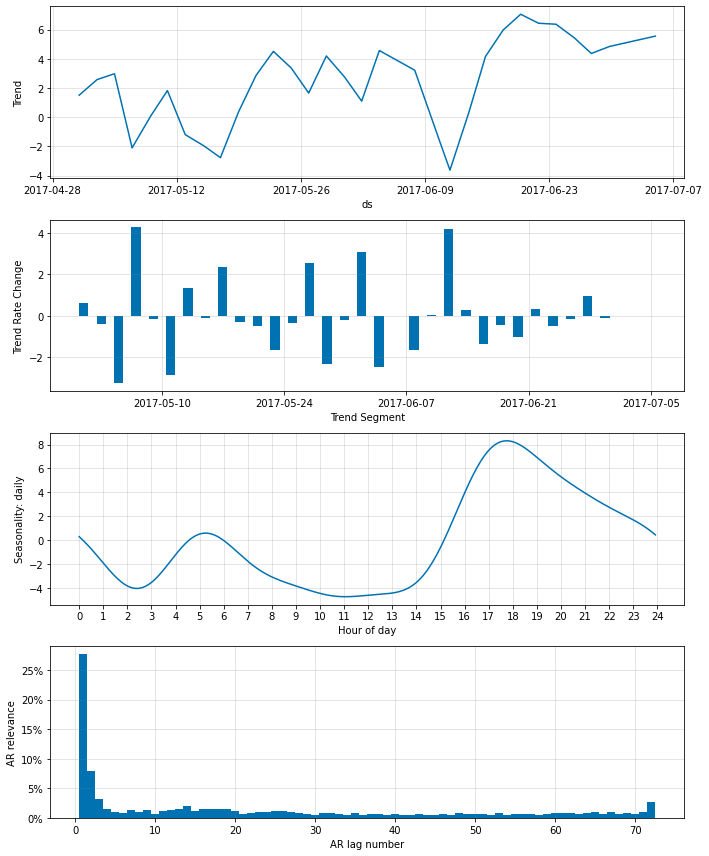

In [45]:
fig_param = m.plot_parameters()

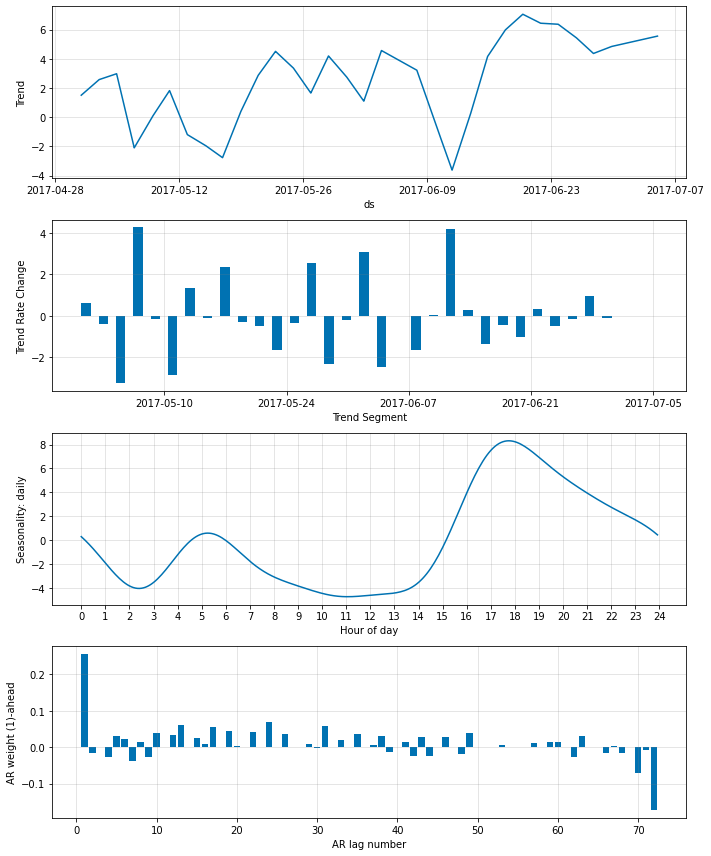

In [46]:
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig_param = m.plot_parameters()

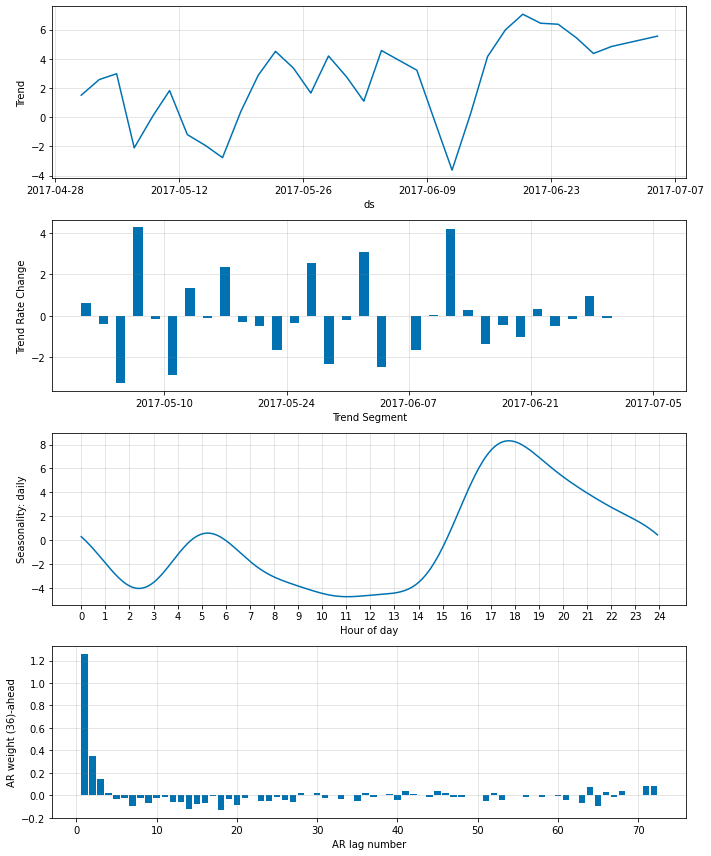

In [47]:
m = m.highlight_nth_step_ahead_of_each_forecast(36)
fig_param = m.plot_parameters()

---
---

# **乗法的季節性**
- NeuralProphetは加法的季節性に適合。**これは予測を得るために季節効果がトレンドに追加される事を意味する**

- **航空旅客数のこの時系列は加法的季節性が機能しない場合の例**

In [48]:
url = 'https://www.salesanalytics.co.jp/591h'
df2 = pd.read_csv(url)
df2.columns = ['ds', 'y']

In [49]:
m = NeuralProphet()
metrics = m.fit(df2, freq="MS")

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.972% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 434


  0%|          | 0/109 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.81E-02, min: 1.47E-01


  0%|          | 0/109 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.62E-02, min: 1.21E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.26E-02
Epoch[434/434]: 100%|██████████| 434/434 [00:08<00:00, 52.71it/s, SmoothL1Loss=0.00171, MAE=17, RMSE=22.4, Loss=0.00124, RegLoss=0]  


In [50]:
future = m.make_future_dataframe(df2, periods=50, n_historic_predictions=len(df))
forecast = m.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.972% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster._make_future_dataframe) - Insufficient data for 18721 historic forecasts, reduced to 144.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.237% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.237% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


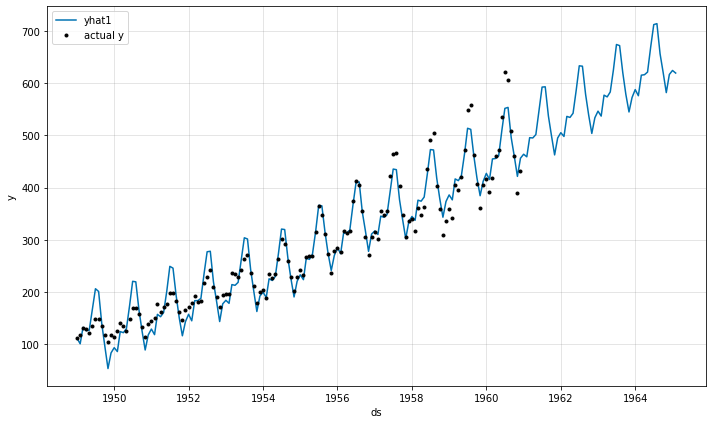

In [51]:
fig = m.plot(forecast)

- この時系列は明瞭な yearly サイクルを持つが、予測の季節性は時系列の開始時にはおおきすぎて終了時には小さすぎる。

- この時系列では、季節性はNeuralProphetにより想定された**定数値の加法的因子ではなく、それはトレンドとともに成長する。**

    - **トレンドと共に成長するという事は、これは乗法的季節性という事。**
    
        - NeuralProphetは入力引数で、seasonality_mode="multiplicative"を設定すうことにより乗法的季節性をモデル化できる

In [54]:
m = NeuralProphet(seasonality_mode="multiplicative")
metrics = m.fit(df2, freq="MS")

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.972% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 434


  0%|          | 0/109 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.81E-02, min: 1.47E-01


  0%|          | 0/109 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.78E+00, min: 1.47E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.30E-01
Epoch[434/434]: 100%|██████████| 434/434 [00:08<00:00, 48.78it/s, SmoothL1Loss=0.000319, MAE=7.74, RMSE=9.59, Loss=0.000252, RegLoss=0]


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.972% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.forecaster._make_future_dataframe) - Insufficient data for 18721 historic forecasts, reduced to 144.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.237% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.237% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


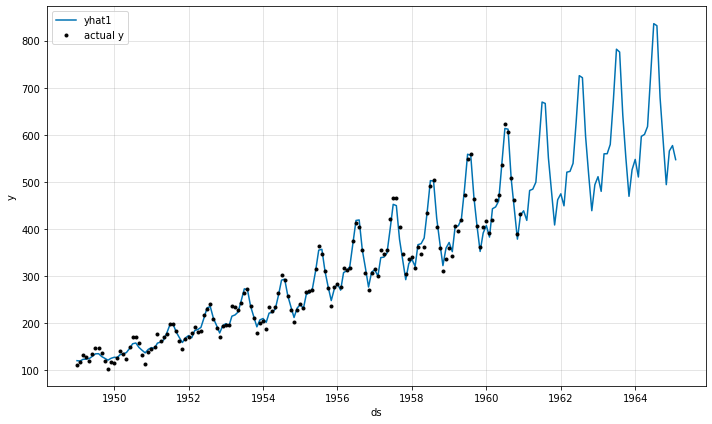

In [55]:
future = m.make_future_dataframe(df2, periods=50, n_historic_predictions=len(df))
forecast = m.predict(future)
fig = m.plot(forecast)

- トレンドのパーセントを示す

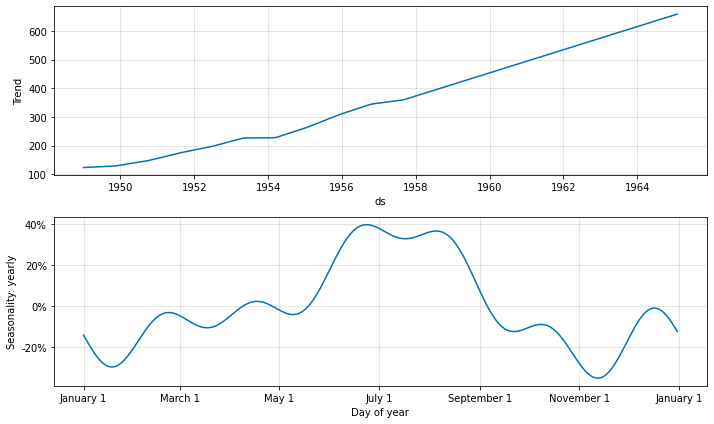

In [56]:
fig_param = m.plot_components(forecast)

- 季節性は月の最初に発生するデータ上でのみ適合している事に注意する

- そのため、月の間の季節性のプロット値はランダム値を取る可能性がある。

- setting seasonality_mode="multiplicative"　は　add_seasonalityで追加されたカスタム季節性を含めて、全ての季節性を乗法的にモデル化する

# **休日と特殊イベントのモデリング**
- モデル化したい休日やほかの繰り返しイベントを持つ場合、それらからデータフレームを作成しなければならない。

- それは２つのカラム(event, ds)と休日の各発生のための行を持ちます。

- それは過去(履歴データが続く限り後方に)未来(予測が成されている限り)の両者の休日を全ての発生を含まなければならない。
    - それらが未来に繰り返されない場合、Prophetはそれらをモデル化してから予測に含めない。

- イベントは加法的か乗法的コンポーネントのいずれかとして追加できる。
    - イベントの前後の日を含める為にウィンドウを定義できる。

In [63]:
data_location = "../input/peyton-manning/example_wp_log_peyton_manning.csv"

df = pd.read_csv(data_location)

In [64]:
## user specified events
# history events
playoffs = pd.DataFrame({
    'event': 'playoff',
    'ds': pd.to_datetime([
        '2008-01-13', '2009-01-03', '2010-01-16',
        '2010-01-24', '2010-02-07', '2011-01-08',
        '2013-01-12', '2014-01-12', '2014-01-19',
        '2014-02-02', '2015-01-11', '2016-01-17',
        '2016-01-24', '2016-02-07',
    ]),
})

superbowls = pd.DataFrame({
    'event': 'superbowl',
    'ds': pd.to_datetime([
        '2010-02-07', '2012-02-05', '2014-02-02', 
        '2016-02-07',
    ]),
})

events_df = pd.concat((playoffs, superbowls))

- **加法的イベント**
    - テーブルが作成されれば、イベント効果は add_events 関数でそれらを追加することでモデルに含まれる
    
    - デフォルトでは、イベントは加法的イベントとしてモデル化される。ここでは、プレーオフの両者を加法的イベントとしてモデル化する
    
    - 更に loss_func を’MSE’に変更する。重みに適合しているイベントが幾つかの稀な外れ値であるため、通常はモデルを少ない外れ値で歪めることを望まない。
        - デフォルトの損失関数は'Huber'

In [65]:
# NeuralProphet Object
m = NeuralProphet(loss_func="MSE")

# set the model to expect these events
m = m.add_events(["playoff", "superbowl"])

# create the data df with events
history_df = m.create_df_with_events(df, events_df)

# fit the model
metrics = m.fit(history_df, freq="D")

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 142


  0%|          | 0/136 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.64E-02, min: 1.17E+00


  0%|          | 0/136 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.41E-02, min: 2.15E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.31E-02
Epoch[142/142]: 100%|██████████| 142/142 [00:27<00:00,  5.11it/s, MSELoss=0.0118, MAE=0.341, RMSE=0.474, Loss=0.00907, RegLoss=0]


In [66]:
# forecast with events
future = m.make_future_dataframe(history_df, events_df, periods=30, n_historic_predictions=len(df))
forecast = m.predict(df=future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.978% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.978% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


- イベント効果は予測データフレームで確認することができます :

In [67]:
events = forecast[(forecast['event_playoff'].abs() + forecast['event_superbowl'].abs()) > 0]
events.tail()

ds          y  residual1      yhat1     trend  season_yearly  \
2190 2014-02-02  11.760520  -0.086026  11.674494  8.314322       0.768719   
2532 2015-01-11   9.886596   0.091840   9.978436  7.940743       0.903722   
2901 2016-01-17   9.273878   0.398476   9.672355  7.536668       1.001717   
2908 2016-01-24        NaN        NaN   9.664730  7.529044       1.001717   
2922 2016-02-07        NaN        NaN  10.690760  7.513796       0.585512   

      season_weekly  events_additive  event_playoff  event_superbowl  
2190       0.018207         2.573244       1.115763         1.457482  
2532       0.018207         1.115763       1.115763         0.000000  
2901       0.018207         1.115763       1.115763         0.000000  
2908       0.018207         1.115763       1.115763         0.000000  
2922       0.018207         2.573244       1.115763         1.457482

- イベント効果はプロットにも現れる。スーパーボウルのための特に大きなスパイクとともに、プレーオフ出場の前後の日々にスパイクがあることがわかる
    - Additive Events で確認できる

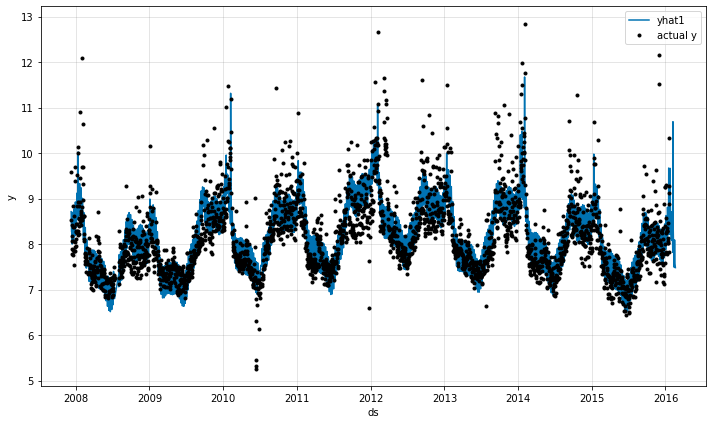

In [68]:
fig = m.plot(forecast)

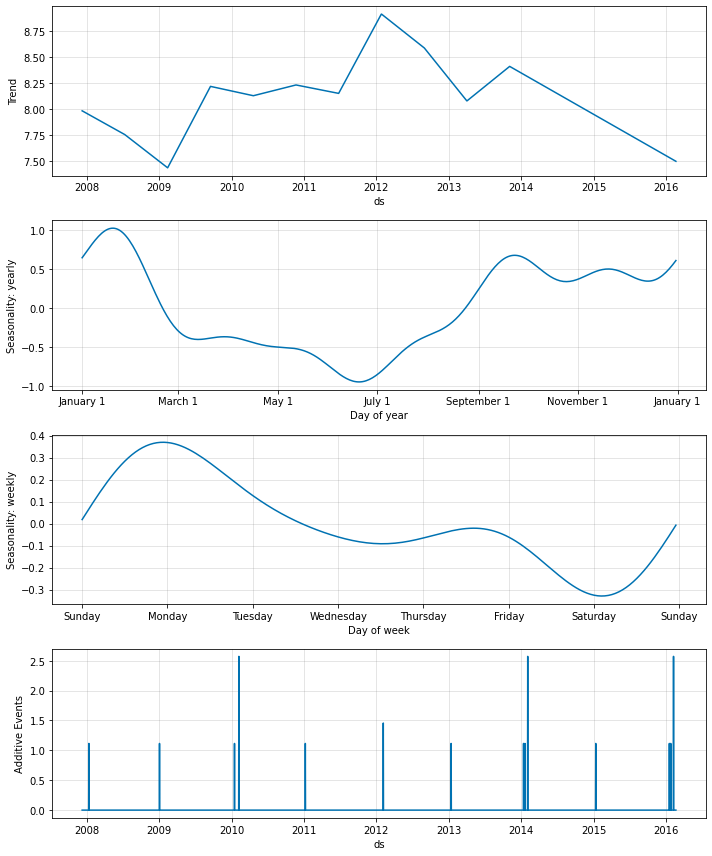

In [69]:
fig_comp = m.plot_components(forecast)

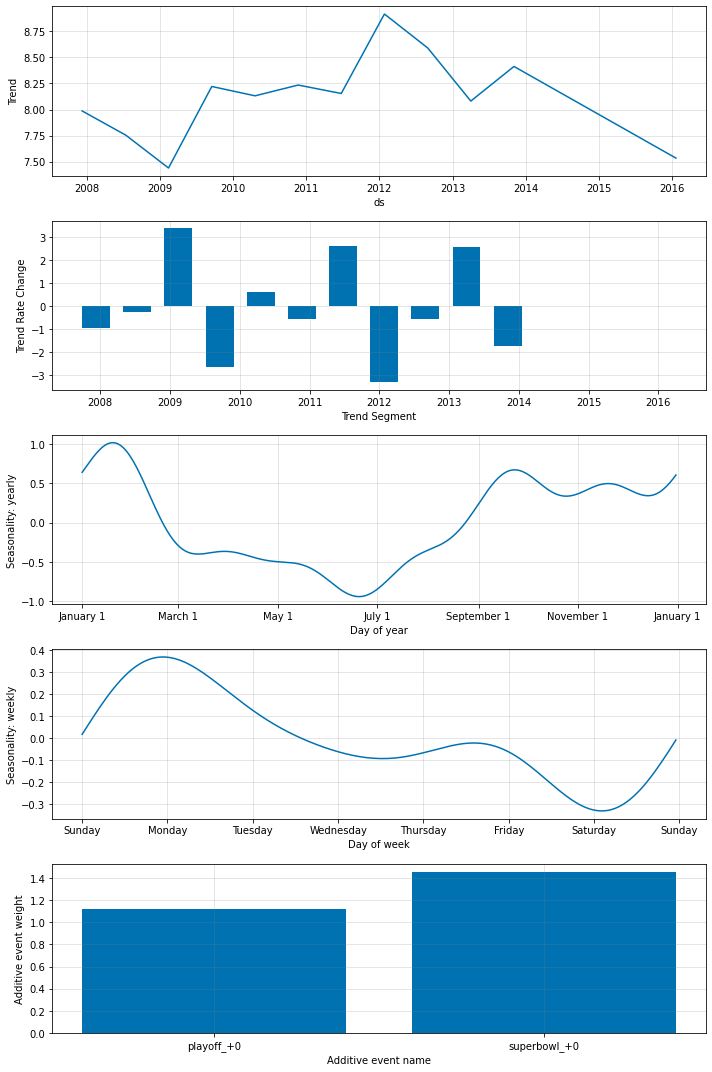

In [70]:
fig_param = m.plot_parameters()

---
---

# **イベント・ウィンドウ**

- 引数lower_window, upper_windowを含めることもできる。
    - これらは休日を日付前後の(lower_window, upper_window) daysに拡張

- クリスマスに加えてクリスマスイブを含めることを望む場合、lower_window=-1, upper_window=0 を含める。
- 感謝祭に加えてブラックフライデーを使用したい場合、lower_window=0, upper_window=1 を含める。

In [71]:
m = NeuralProphet(loss_func="MSE")

# set event configs to NeuralProphet object with windows
m = m.add_events(["playoff"], upper_window=1)
m = m.add_events(["superbowl"], lower_window=-1, upper_window=1)

# create the data df with events
history_df = m.create_df_with_events(df, events_df)

# fit the model
metrics = m.fit(history_df, freq="D")

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 142


  0%|          | 0/136 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.36E-02, min: 2.15E+00


  0%|          | 0/136 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.31E-02, min: 2.15E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.74E-02
Epoch[142/142]: 100%|██████████| 142/142 [00:28<00:00,  4.97it/s, MSELoss=0.0109, MAE=0.331, RMSE=0.454, Loss=0.00835, RegLoss=0]


In [72]:
# make future dataframe with events known in future
future = m.make_future_dataframe(df=history_df, events_df=events_df, periods=365, n_historic_predictions=len(df))
forecast = m.predict(df=future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.083% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.083% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


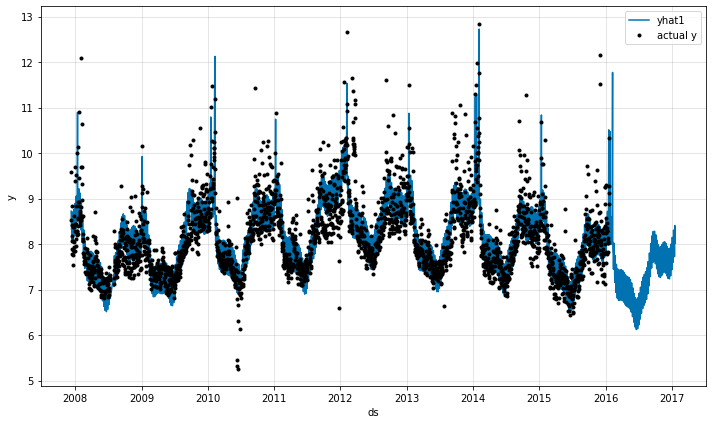

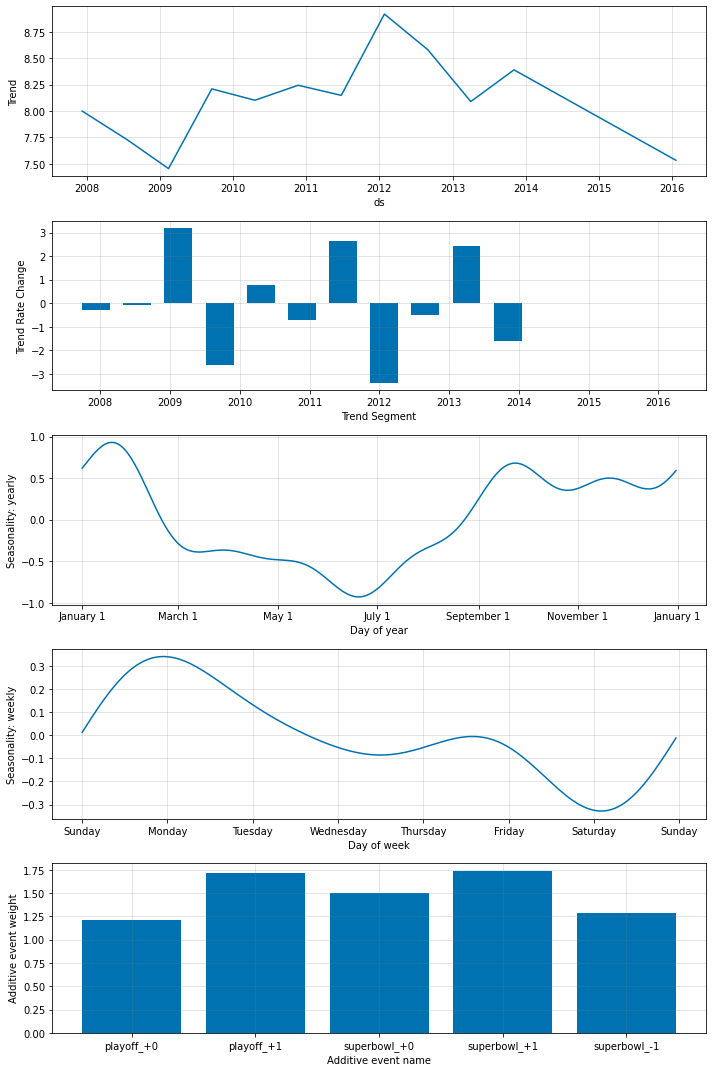

In [73]:
## plotting parameters
fig = m.plot(forecast)
fig_param = m.plot_parameters()

---
---

# **乗法的イベント**

In [74]:
m = NeuralProphet(loss_func="MSE")

# set event configs to NeuralProphet object with windows
m = m.add_events(["playoff"], upper_window=1)
m = m.add_events(["superbowl"], lower_window=-1, upper_window=1, mode="multiplicative")

# create the data df with events
history_df = m.create_df_with_events(df, events_df)

# fit the model
metrics = m.fit(history_df, freq="D")

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 142


  0%|          | 0/136 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.17E-01, min: 1.85E+00


  0%|          | 0/136 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.17E-01, min: 1.58E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.11E-01
Epoch[142/142]: 100%|██████████| 142/142 [00:30<00:00,  4.73it/s, MSELoss=0.0109, MAE=0.331, RMSE=0.456, Loss=0.00835, RegLoss=0]


In [75]:
# make future dataframe with events known in future
future = m.make_future_dataframe(history_df, events_df, periods=30, n_historic_predictions=len(df))
forecast = m.predict(df=future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.978% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.978% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


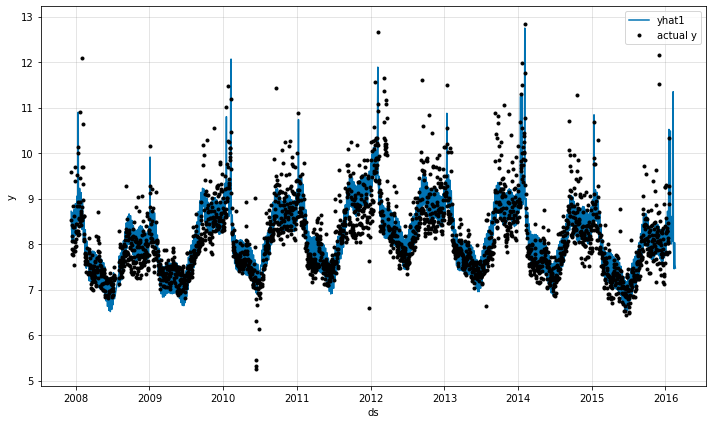

In [76]:
## plotting components
fig_comp = m.plot(forecast)

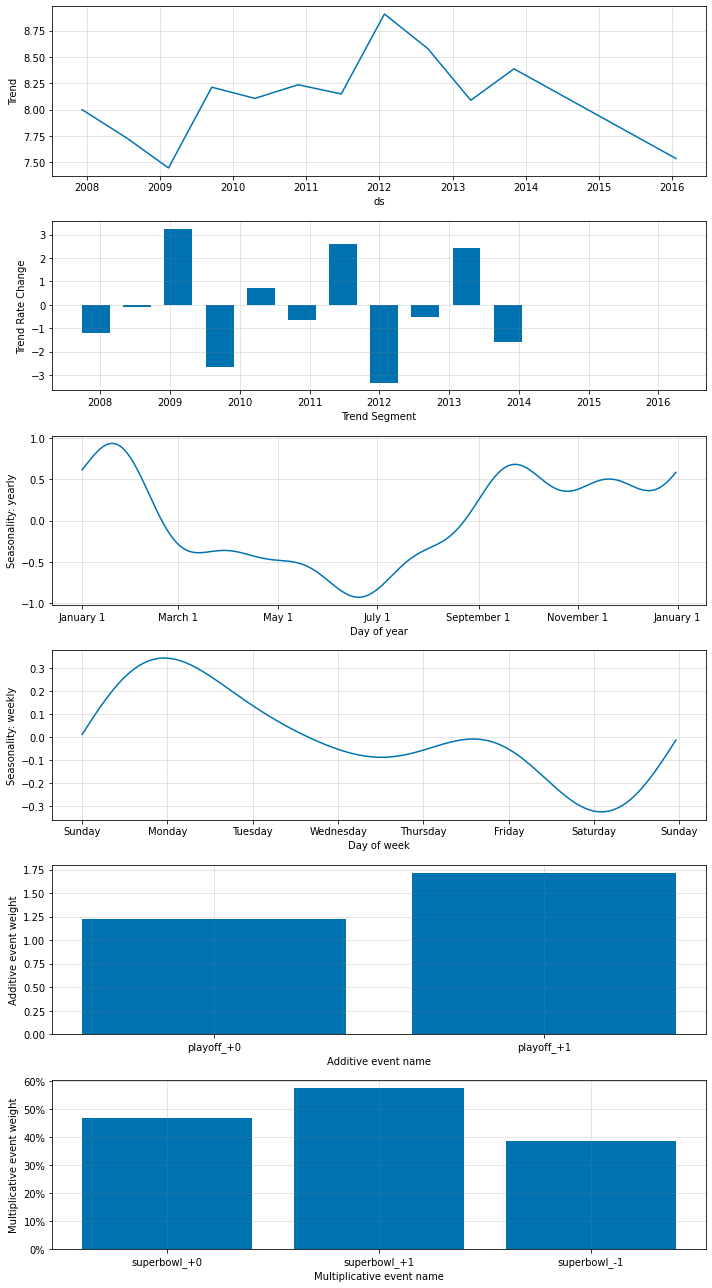

In [77]:
# plot parameters
fig_param = m.plot_parameters()

---
---

# **国固有の休日**

In [78]:
m = NeuralProphet()

# add the country specific holidays
m = m.add_country_holidays("US")

# fit the model
metrics = m.fit(df, freq="D")

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 142


  0%|          | 0/136 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.36E-01, min: 8.58E-02


  0%|          | 0/136 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.31E-01, min: 2.51E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.59E-01
Epoch[142/142]: 100%|██████████| 142/142 [00:28<00:00,  4.99it/s, SmoothL1Loss=0.00597, MAE=0.342, RMSE=0.472, Loss=0.00458, RegLoss=0]


In [79]:
# make future dataframe with events known in future
future = m.make_future_dataframe(df=df, periods=30, n_historic_predictions=len(df))
forecast = m.predict(df=future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.978% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.978% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


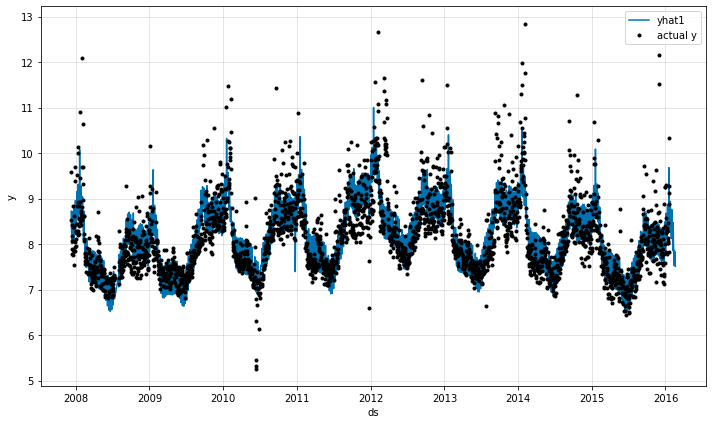

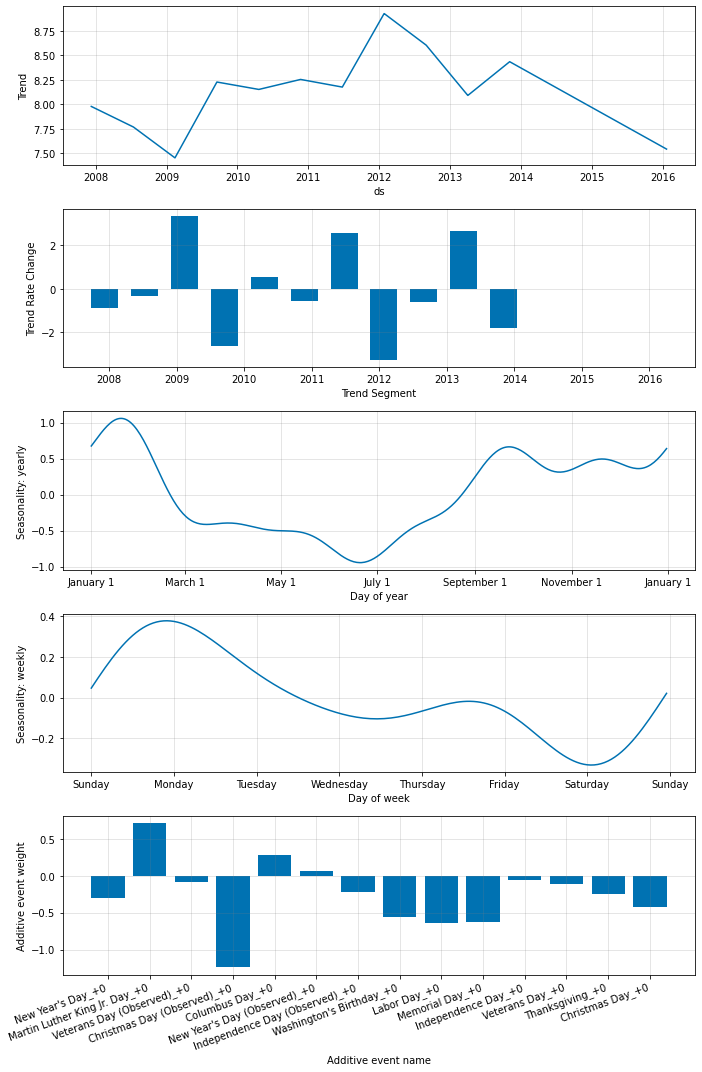

In [80]:
## plotting components
fig = m.plot(forecast)
fig_param = m.plot_parameters()

---
---

# **再生可能エネルギー: 1 時間あたりの日射量の予測**

- トレーニングはデータの 90% で行われ、最後の 10% は評価用に予約
    - **一般的な予測: 時間ベースの機能のみ**
    
- この最初のセクションでは、Facebook Prophet で行うように、時間機能のみを使用してモデルをトレーニングします。
    - 最初から、太陽の強さが時間帯と季節に依存することはわかっています。
    - さらに、毎日のピーク強度は季節に比例することがわかっています。
    - 現時点では、Prophet も NeuralProphet も 2 つの季節性を掛け合わせることができないため、ピークは夏に低くなり、冬にマイナスになる可能性があります。
    - 理想的ではありませんが、最初の試みには問題ありません。

In [101]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/energy/SF_PV.csv"
raw = pd.read_csv(data_location)

In [102]:
m = NeuralProphet(
    yearly_seasonality=3,
    weekly_seasonality=False,
    daily_seasonality=8,
    growth="off",
    learning_rate=0.1,
)



In [103]:
df_train, df_test = m.split_df(raw, freq="H", valid_p=0.10)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [104]:
metrics = m.fit(df_train, freq="H", validation_df=df_test, progress="plot")

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 109
WARNING - (NP.forecaster._train) - To plot live loss, please install neuralprophet[live].Using pip: 'pip install neuralprophet[live]'Or install the missing package manually: 'pip install livelossplot'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neuralprophet/forecaster.py", line 2383, in _train
    from livelossplot import PlotLosses
ModuleNotFoundError: No module named 'livelossplot'
Epoch[109/109]: 100%|██████████| 109/109 [00:40<00:00,  2.68it/s, SmoothL1Loss=0.00921, MAE=92.1, RMSE=118, Loss=0.0067, RegLoss=0, MAE_val=25

---
---

# 時系列データ分析

In [13]:
stock_df = pd.read_csv('../input/tesla-stock-data-from-2010-to-2020/TSLA.csv')

In [14]:
time_series = stock_df.copy()
time_series["Date"] = pd.to_datetime(stock_df["Date"])
time_series = time_series.set_index(["Date"]).sort_index(ascending=True)

In [15]:
plt.rcParams["figure.figsize"] = [20,10]
plt.rcParams["font.size"] = 15

In [16]:
def plt_seasonal_decompose(df, col_name, period):
    res = sm.tsa.seasonal_decompose(df[col_name], period=period)
    fig = res.plot()
    plt.show()

- 1番目のグラフが現系列
- 2番目のグラフが傾向変動(Trend)
- 3番目のグラフが季節変動(Seasonal)
- 4番目のグラフが不規則変動(Resid(残差))

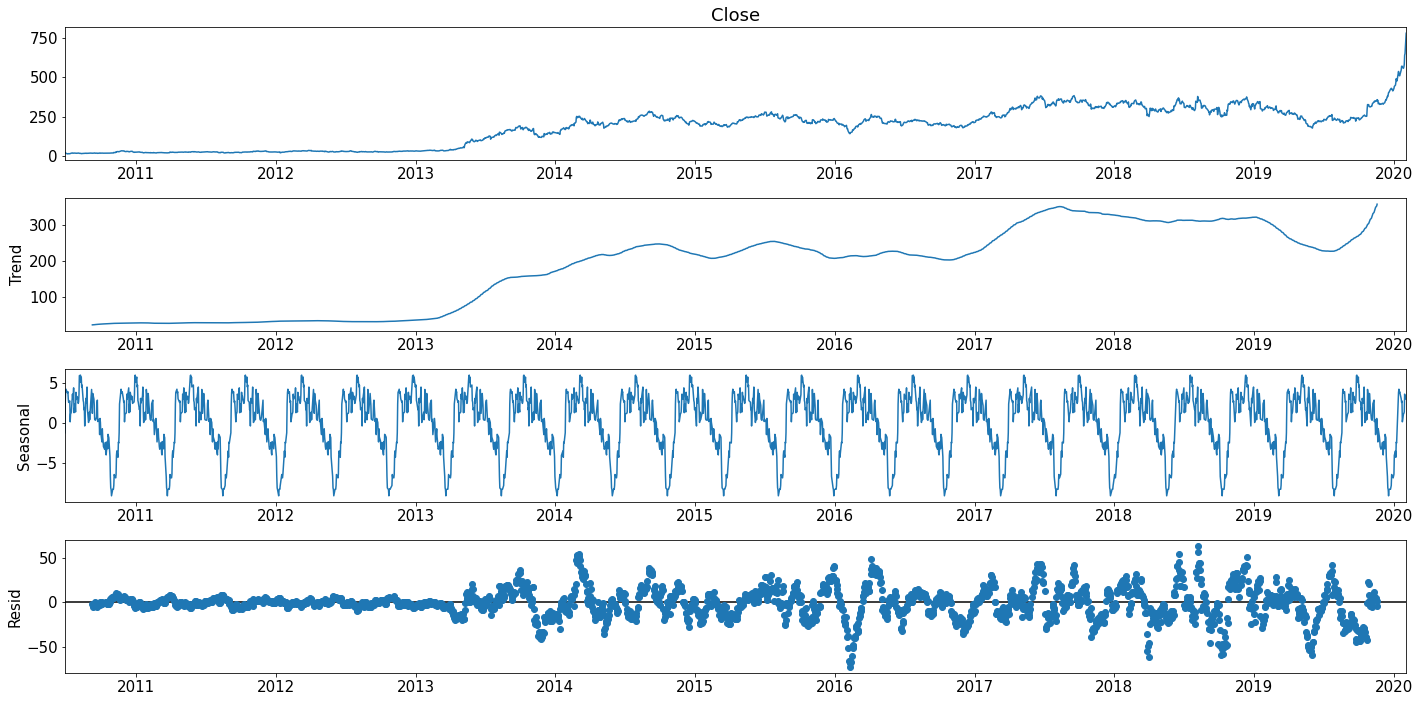

In [17]:
import statsmodels.api as sm

plt_seasonal_decompose(time_series, col_name='Close', period=100)

# **定常性と非定常性**
- **定常性と非定常性の違いと可視化による認識の違い**
    - **定常性とは**　:　時間経過による影響を(強く)受けない状態の事
        - **定常過程とは** : その確率的な変動の性質が、各時点に依存せず一定であるような確率過程の事
            - 各期の平均が普遍であるとみなせる、上昇(下降)の傾向がないデータの事：つまり一定の直進し上限する線分
                - 携帯アラームの周波数など、平均0の周辺で一定の分散をもってランダムに振動し続けるデータは、(弱)定常性があると言える
                - 反対に、明らかな上昇傾向が存在し続けている株価の動きなどは、定常性があるとは言えない。これは、**非定常過程**という
      　
       
        - **非定常過程** 　:　グラフの右側へ進むにつれて変動(上昇傾向)がある
                

In [18]:
stock_df['Close'].mean(), stock_df['Close'].var()

(186.40365078187088, 14193.391255803246)

- 時系列データについての説明のため、先に基本の4成分(傾向変動等)に触れる、(成分分解をする前に)そもそも定常性があるのかを確認する必要があるため、まずは定常性の条件である「平均」「分散」を確認する。

- (弱)定常性の定義は、「平均0の周辺で一定の分散をもってランダムに振動を続けるデータ」
- 上記はCloseはかなりばらつきのあるデータと言える。
    - **後ほど定常性となりえなかった要因の成分を取り除き、再度確認する**
    
- **時系列データ分析とは**
    - 時系列データ分析とは、**ある一定間隔の時間に対して観測されている**データの周期性や傾向から将来を予測する手法のことを言う。
    - これにより近い将来を把握し、施策の検討や対策を打つことが可能となる。

# **周期性**
- 周期性(周期的変動)とは、時系列が一定の間隔でおなじような変動を繰り返す成分、またはその状態を指す
    - 周期性を可視化する方法としてコレログラムがある。
        - **コレログラム**とは、ラグと自己相関を表したグラフ
        - ラグとは、元のデータからどれほど時間をずらしているかを表す指標のこと
            - 元データｘから時間をずらしたデータｙとの相関係数を表すグラフであり、横軸にラグ、縦軸に自己相関

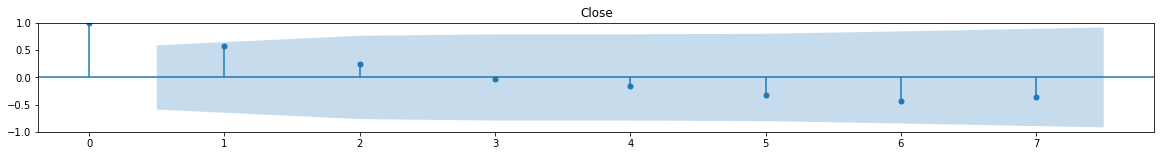

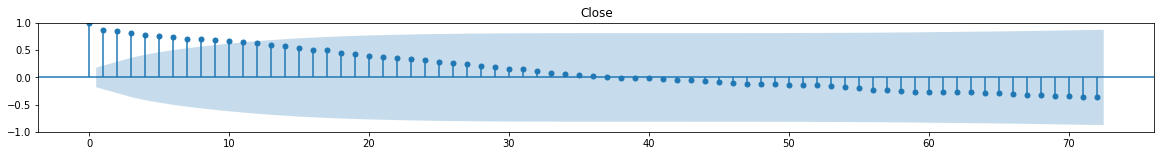

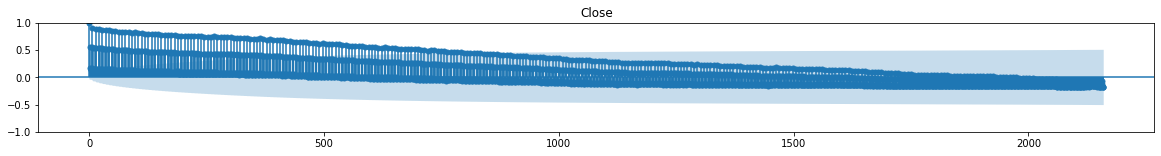

In [19]:
# 表示サイズ調整
plt.rcParams["figure.figsize"] = [20,2]
plt.rcParams["font.size"] = 10

# コレログラム
def correlogram(cicle, lags, df, feature):
    sm.graphics.tsa.plot_acf(df.resample(cicle)[feature].sum(), title=feature, lags=lags)

# まずは原系列をインプットして確認
correlogram(cicle='Y', lags='7', df=time_series, feature='Close') # 年ベース
correlogram(cicle='M', lags=str(12*6), df=time_series, feature='Close') # 月ベース
correlogram(cicle='D', lags=str(30*12*6), df=time_series, feature='Close') # 日ベース

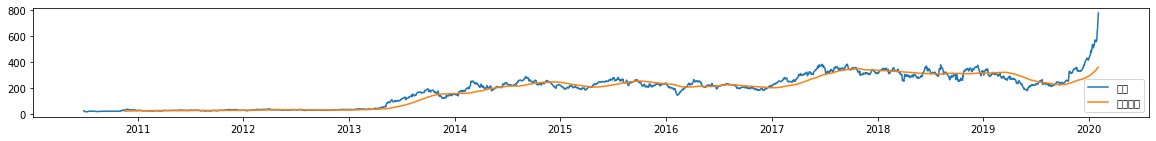

In [21]:
# インデックスに['Date']（時間情報）を設定
stock = stock_df.copy()
stock["Date"] = pd.to_datetime(stock['Date'])
stock = stock.set_index(['Date']).sort_index(ascending=True)

# 移動平均
stock['Close_move_mean'] = stock['Close'].rolling(100).mean().round(1)
plt.plot(stock['Close'], label='終値')
plt.plot(stock['Close_move_mean'], label='移動平均')
plt.legend(loc='lower right')
plt.show();

In [22]:
def adf_test(series):
    adf_df = pd.DataFrame(
        [
            sm.tsa.stattools.adfuller(series)[1] # ADF検定　:　定常性の確認
        ],
        columns=['P値']
    )
    adf_df['P値'] = adf_df['P値'].round(decimals=3).astype(str)
    print(adf_df)

# 原系列のp値を算出
adf_test(series=time_series['Close'])

      P値
0  0.997


- p値が99.７％なので非定常性であると判断できる。
    - 定常性を持たない場合、そのままの状態ではデータの特徴や関係性を正しくとらえられない為
    - 定常性を持つようなデータに変換が必要になる。
        - **ここでデータを変換する**
            - データの変換方法にもいくつかあり、ここでデータから非定常性を取り除く。
                - **差分変換**
                - **対数変換**
                - **対数差分変換**

# **差分変換**
- 差分を取る事で、上昇傾向が取り除かれ、平均が0の正常過程の状態に近づけることが出来る。
- y軸のスケールが変換前後で変わるのもポイント

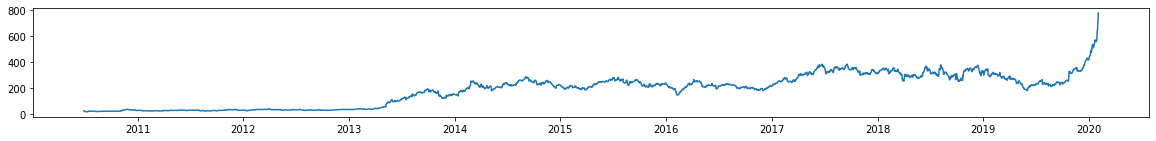

In [23]:
# Dataをインデックスに設定
time_series = stock_df.copy()
time_series["Date"] = pd.to_datetime(stock_df['Date'])
time_series = time_series.set_index(['Date']).sort_index(ascending=True)

# 原系列のプロット
plt.plot(time_series['Close'])

<AxesSubplot:xlabel='Date'>

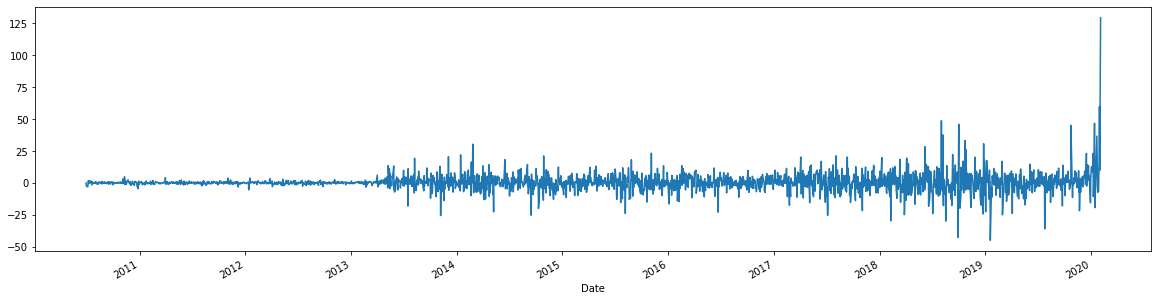

In [24]:
# 差分変換後のプロット
time_proc = time_series.copy()
Passengers_diff_c = time_proc["Close"].diff(periods = 1) # 差分変換
Passengers_diff_c.plot(figsize=[20,5])

In [25]:
Passengers_diff_c.mean(), Passengers_diff_c.var()

(0.31308902732919247, 49.91006436772916)

# **対数変換**

- 対数変換とは、変動が著しく大きな時系列データに対し、対数値変換によって元の時系列原子データの傾向を保持したまま、値を小さく変換する手法
    - 変動の分散を一様にし、複雑な時系列でも変数変換で分析が簡単になることがある
        - 

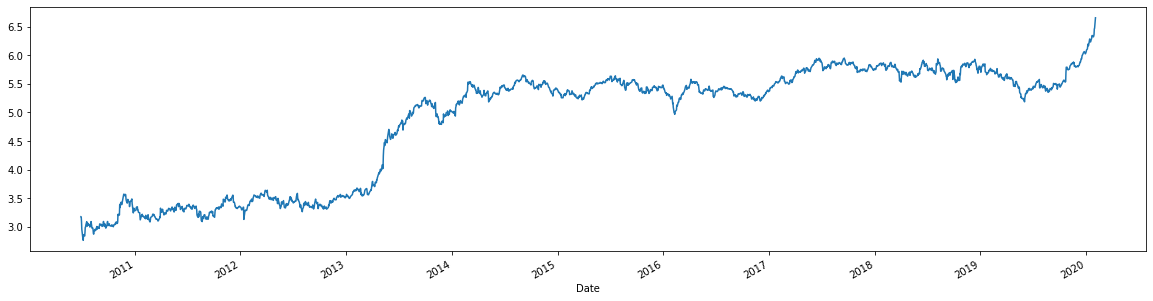

In [32]:
passengers_log_c = np.log(time_proc["Close"])
passengers_log_c.plot(figsize=[20, 5])

In [31]:
passengers_log_c.mean(), passengers_log_c.var()

(4.855657071213902, 1.0282004603767312)

# **対数差分変換**
- 対数差分変換とは、対数変換と差分変換の両方の変換を施す手法
    - 時系列データが変化率や成長率などである場合、対数差分を計算して解析する事がある：$\Delta\log{(y_{t})} = \log{(y_{t}/y_{t - 1})}$

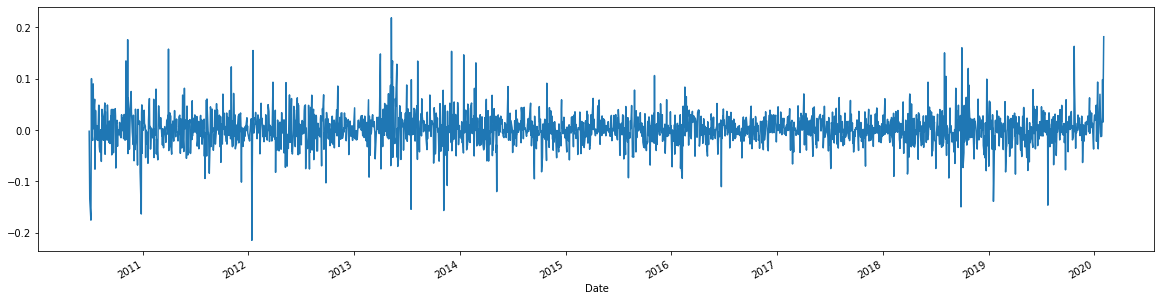

In [33]:
passengers_log_diff_c = passengers_log_c.diff(periods = 1)
passengers_log_diff_c.plot(figsize=[20,5]);

# **再度ADF検定**

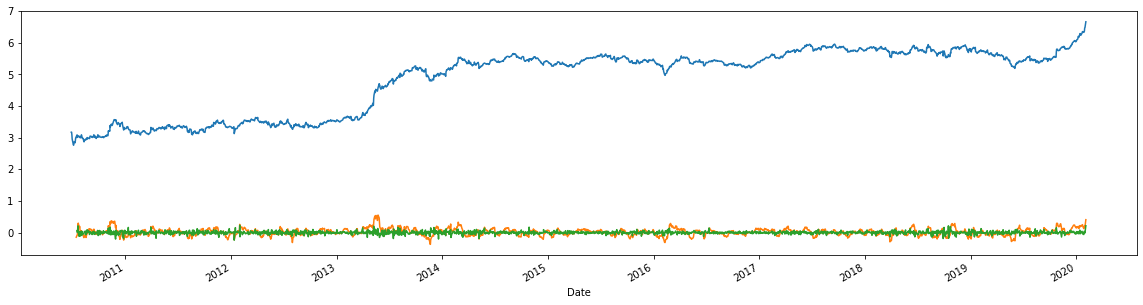

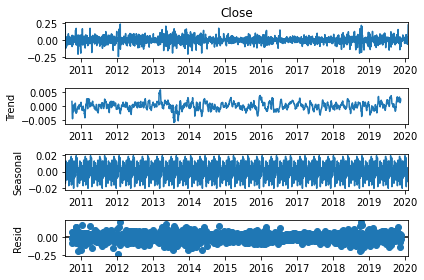

    P値
0  0.0


In [34]:
# 対数変換
Passengers_log_c = np.log(time_proc["Close"])
Passengers_log_c.plot(figsize=[20,5]);

# 季節差分変換
Passengers_log_sdiff_c = Passengers_log_c.diff(periods = 12) # 季節：periods = 12
Passengers_log_sdiff_c.plot(figsize=[20,5]);

# ラグ1の差分を取る
Passengers_sdiff2_c = Passengers_log_sdiff_c.diff()
Passengers_sdiff2_c.plot(figsize=[20,5]);

# 変換済みデータの欠損の削除
Passengers_sdiff2_c2 = Passengers_sdiff2_c.dropna()

# 成分分解（季節調整）
res = sm.tsa.seasonal_decompose(Passengers_sdiff2_c2, period=100)
fig = res.plot()
plt.show()

# 原系列のp値を算出 : ADF検定
adf_test(series=Passengers_sdiff2_c2)

- 元は0.997という数値だったが0.0になっているので、定常性であるといえるように変換されている。
- 有意水準0.05(5%)は届いているので、仮説は棄却出来る。

    - 0.05%に届いていなければ、その状態では解析を行えない。
    
        - この場合は、なぜ定常性がないのかを考察する必要がある。
        
        - 特徴量が非常にシンプルなデータセットを用いているが、本来はそれ以上の特徴量を追加・生成するなどの対応も必要
        
        - **定常・非定常**に左右されない分析手法を採用する、

- ●時系列データにおける特徴量作成
    - 時系列データでは下記の特徴量(生成)が有効となるケースがある。
        - 月、曜日、終末フラグ、祝日、休日など。

# **特徴量エンジニアリング**
- 特徴量エンジニアリングとは、手持ちのデータからドメイン知識などを駆使し、新たな特徴量を生成する取り組みの事。

- なぜ特徴量エンジニアリングが必要なのか、それはデータの質を向上させ、より無駄がなく、より意味のあるデータを機械学習のモデルに学習させる。

# ドメイン
- ドメインとは、手持ちのデータが属する業界や事業等、その領域における専門知識・知見・トレンドなどを表す懸念
    
- データが生み出される仕組みや背景・経緯を知っている事で、データの構造、特徴や傾向をより深く・広く把握することができるため。
    
- このように、ドメイン知識がデータ解析の結果・精度に大きく影響する為、ドメイン知識の習得・理解が不可欠になる。

***
    
- 不均衡データ
    - 予測したい事象が非常に少ないデータを「不均衡データ」と呼ぶ。不均衡データの場合は、特別な対応が必要となる。
        
    - データ構造に偏りがあり、正または負データの片方が極端に少ないデータ群の事を言う。
        
    - (例)：ラベル0：284315(99.83%)　ラベル1: 492(0.17%)　/ のようなデータ例
        
- 不均衡データの問題点
    - 正例データが非常に多く、負データが極端に少ないデータを用いて予測モデルを構築した場合、予測結果は正となる事が多い。
        - 予測結果のほとんどが正例となることで、一見精度(Accuracy：正解率)は高く評価されるが、適合率(Precision)・再現率(Recall)は低い結果となる。
            - Accuray99.0　Recall0　Precision0　のような状態になる
    - 不均衡データのもう一つの問題として、”余計な”計算コスト
    
- 不均衡データを扱う際の注意点
    - 不均衡データをそのまま分析、学習に使うのは問題
        - 不均衡データを扱う際、分析、学習目的に即した対応が必要になる。
            - 例えば学習の結果、正解率(Accuracy)が高い予測モデルを構築することが目的だった場合を仮定 ：**根本的に分類問題では、正解率は間違い。混同行列が正解**
                - 負数を予測したい場合、上記の例のような不均衡データを使うと不均衡目的と合致しない予測モデルができあがってしまうことになる。
                    - **不均衡データを扱う際**には、その主目的、および想定の評価結果に即した対応が必要となる。
                    
- 不均衡データの発生原因
    - 正または負データの発生確率が極端に低いケースがあげられる。
        - 非常に稀な病気の発生有無と観測した場合、データの大半は未発症(負)になり、発生者(正)はごく稀
        - 例えば店舗での取り扱い数の少ない商品分類の購入予測を行う際にも、対象カテゴリーの母数がそもそも少ないことから、その購買履歴は不均衡データとなってしまうケースがある

- 不均衡データに対するアプローチ(代表される５つのアプローチ)
    - **アンダーサンプリング**
        - 多数派のデータを少数派のデータ数に合わせて削除する手法　/ 正と負数を合わせるという事
        - **注意点**
            - 多数派のデータを削除している為、重要なデータまでもが欠損し、元の多数派のデータに対しバイアスが生じる原因
                - 確率予測をする場合、アンダーサンプリングを行ったデータで構築したモデルが出力する予測確率に生じるバイアスを除去し、補助する必要が生じる
                    - [アンダーサンプリングによるバイアスの補正方法](https://www3.nd.edu/~dial/publications/dalpozzolo2015calibrating.pdf)
            - 学習した分類器・予測器の出力の分散が大きくなる(ことがある)という問題がある。
                - アンダーサンプリング後のデータ量が十分でない場合、的確な予測ができず予測結果にちらばりが生じる
    - **アンダーバギング**
        - アンダーバギングという手法は、アンダーサンプリングを実施してk通りの部分集合を作成し、各部分集合ごとに分類器を学習し、バギングでアンサンブルをする手法
            - バギングは、ブートストラップサンプリング手法を用いて生成したデータを、複数のモデルでそれぞれ学習する方法
                - **ブートストラップサンプリング**とは、置換を伴うランダムサンプリングの事で、これにより**データの平滑化(偏りをなくす)**を行う
                - ・$DataSet>\left. \begin{bmatrix} 訓練データ \\
                訓練データ\\\vdots\\訓練データ
\end{bmatrix}
\quad
\right\} \left. \begin{bmatrix} 予測モデル \\
                予測モデル\\\vdots\\予測モデル
\end{bmatrix}
\quad
\right\} 予測値
$
                    - アンダーサンプリングした訓練データに対して、予測を行う。これを複数行い、最終的な予測を一つにバギング(アンサンブル)として纏める
    - **オーバーサンプリング**
        - 少数派のデータを多数派のデータ数に合わせて増やしていく手法
            - 【注意】: オーバーサンプリングの注意点として、無秩序に少数派のデータを増やしても、同じようなデータが増えて過学習に陥る、汎化性能の低い予測モデルを構築してしまう
            - 【対処】: 対処方法**SMOTE(Synthetic Minority Oversampling TEchnique)**
                - ランダムサンプリングのデータと、k近傍法のアルゴリズムで求められたデータにより、合成データを作成する方法
                    - SMOTEはまず少数派のデータからランダムでデータを選択し、そのデータからランダムで選択された近傍点を用いて、両者の合成データを作成する。　：　$K=3(例)$
                        - ある点を中心として、近傍点を$k=3$選択し、その中からランダムで１つの近傍点を選択し中心点と近傍点の間に新たなサンプルを生成する
                        
    - **重み付け**
        - 少数派のサンプルに重み付けを行い(重要視して)、少数派のカテゴリをより的確に分類できるようにする手法
            - 重み付けとは、目的関数を誤差に対し(少数派データのラベルごとに)ペナルティを与え、少数派のデータの学習を重視して学習を行う方法
                - 決定木系のモデルでは、損失関数を元に分類を行うが、そもそも正、負のサンプル少ない場合は、損失に影響を及ぼしにくい為、重み付けを行う必要がある
        - 重み付けのメリットとして、メモリを節約して不均衡データに対応できるようになることがある。
            - オーバーサンプリングのように、データ量の増加は発生しない為
                - 重み付け注意点として、重み付け学習データにのみ行い、検証データ、テストデータに対しては重み付けを行ってはいけない
                    - 実際のデータの比率に対しての精度を見て評価を行う為。
    
    - **異常検知問題として扱う**
        - あまりにもデータに偏りがありデータが不足しており、尚且つ少数派のデータがクラスターを作れていない場合、分類問題とそて扱うのは困難なケースがある
            - この場合、分類問題ではなく、異常検知問題としてのアプローチが有効なケースがある
                - 正常データ群からの距離や密度の違いに着目し、事前に定めた閾値(しきい値)を超えたデータを異常値として判定する： **外れ値検知**
                    - 正常データ群のうち、異常データ群に該当する箇所
                - Local Outlier Factor(LOF)
                    - K近傍法ベースのアルゴリズム
                - One-class SVM
                    - サポートベクトルマシンの改良版
                - Isolation Forest(ISO)
                    - ランダムフォレストと似たアルゴリズム
                    